In [25]:
import pandas as pd
import numpy as np
import spacy
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Data Loading & simple EDA

In [26]:
# Load data
data = pd.read_csv('.\Job_Postings_Dataset_(2021-2023).csv')

In [4]:
rows, cols = data.shape
print ('Number of Records:', rows)
print ('Number of Features:', cols)

Number of Records: 1615940
Number of Features: 23


In [5]:
# Display the structure of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615940 entries, 0 to 1615939
Data columns (total 23 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Job Id            1615940 non-null  int64  
 1   Experience        1615940 non-null  object 
 2   Qualifications    1615940 non-null  object 
 3   Salary Range      1615940 non-null  object 
 4   location          1615940 non-null  object 
 5   Country           1615940 non-null  object 
 6   latitude          1615940 non-null  float64
 7   longitude         1615940 non-null  float64
 8   Work Type         1615940 non-null  object 
 9   Company Size      1615940 non-null  int64  
 10  Job Posting Date  1615940 non-null  object 
 11  Preference        1615940 non-null  object 
 12  Contact Person    1615940 non-null  object 
 13  Contact           1615940 non-null  object 
 14  Job Title         1615940 non-null  object 
 15  Role              1615940 non-null  object 
 16  

In [6]:
# Check for missing values
data.isnull().sum()

Job Id                 0
Experience             0
Qualifications         0
Salary Range           0
location               0
Country                0
latitude               0
longitude              0
Work Type              0
Company Size           0
Job Posting Date       0
Preference             0
Contact Person         0
Contact                0
Job Title              0
Role                   0
Job Portal             0
Job Description        0
Benefits               0
skills                 0
Responsibilities       0
Company                0
Company Profile     5478
dtype: int64

In [7]:
# Display the number of unique values for each column
data.nunique()

Job Id              1615940
Experience               48
Qualifications           10
Salary Range            561
location                214
Country                 216
latitude                216
longitude               216
Work Type                 5
Company Size         122188
Job Posting Date        731
Preference                3
Contact Person       367128
Contact             1615933
Job Title               147
Role                    376
Job Portal               16
Job Description         376
Benefits                 11
skills                  376
Responsibilities        375
Company                 888
Company Profile         884
dtype: int64

In [27]:
data.head()

,Job Id,Experience,Qualifications,Salary Range,location,Country,latitude,longitude,Work Type,Company Size,Job Posting Date,Preference,Contact Person,Contact,Job Title,Role,Job Portal,Job Description,Benefits,skills,Responsibilities,Company,Company Profile
0,1089843540111562,5 to 15 Years,M.Tech,$59K-$99K,Douglas,Isle of Man,54.2361,-4.5481,Intern,26801,2022-04-24,Female,Brandon Cunningham,001-381-930-7517x737,Digital Marketing Specialist,Social Media Manager,Snagajob,Social Media Managers oversee an organizations...,"{'Flexible Spending Accounts (FSAs), Relocatio...","Social media platforms (e.g., Facebook, Twitte...","Manage and grow social media accounts, create ...",Icahn Enterprises,"{""Sector"":""Diversified"",""Industry"":""Diversifie..."
1,398454096642776,2 to 12 Years,BCA,$56K-$116K,Ashgabat,Turkmenistan,38.9697,59.5563,Intern,100340,2022-12-19,Female,Francisco Larsen,461-509-4216,Web Developer,Frontend Web Developer,Idealist,Frontend Web Developers design and implement u...,"{'Health Insurance, Retirement Plans, Paid Tim...","HTML, CSS, JavaScript Frontend frameworks (e.g...","Design and code user interfaces for websites, ...",PNC Financial Services Group,"{""Sector"":""Financial Services"",""Industry"":""Com..."
2,481640072963533,0 to 12 Years,PhD,$61K-$104K,Macao,"Macao SAR, China",22.1987,113.5439,Temporary,84525,2022-09-14,Male,Gary Gibson,9687619505,Operations Manager,Quality Control Manager,Jobs2Careers,Quality Control Managers establish and enforce...,"{'Legal Assistance, Bonuses and Incentive Prog...",Quality control processes and methodologies St...,Establish and enforce quality control standard...,United Services Automobile Assn.,"{""Sector"":""Insurance"",""Industry"":""Insurance: P..."
3,688192671473044,4 to 11 Years,PhD,$65K-$91K,Porto-Novo,Benin,9.3077,2.3158,Full-Time,129896,2023-02-25,Female,Joy Lucero,+1-820-643-5431x47576,Network Engineer,Wireless Network Engineer,FlexJobs,"Wireless Network Engineers design, implement, ...","{'Transportation Benefits, Professional Develo...",Wireless network design and architecture Wi-Fi...,"Design, configure, and optimize wireless netwo...",Hess,"{""Sector"":""Energy"",""Industry"":""Mining, Crude-O..."
4,117057806156508,1 to 12 Years,MBA,$64K-$87K,Santiago,Chile,-35.6751,-71.5429,Intern,53944,2022-10-11,Female,Julie Johnson,343.975.4702x9340,Event Manager,Conference Manager,Jobs2Careers,A Conference Manager coordinates and manages c...,"{'Flexible Spending Accounts (FSAs), Relocatio...",Event planning Conference logistics Budget man...,Specialize in conference and convention planni...,Cairn Energy,"{""Sector"":""Energy"",""Industry"":""Energy - Oil & ..."


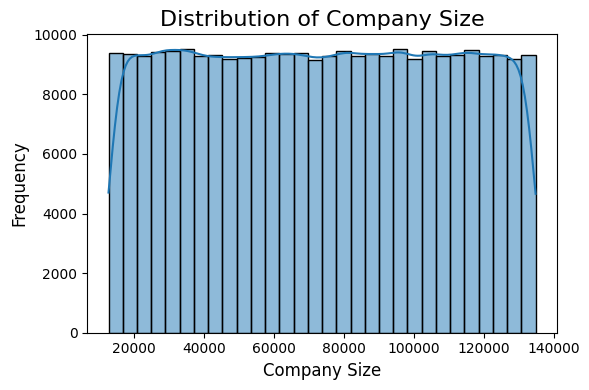

In [11]:
# Create a histogram for Company Size with a KDE overlay
plt.figure(figsize=(6, 4))
sns.histplot(data['Company Size'], kde=True, bins=30)

# Add title and labels
plt.title('Distribution of Company Size', fontsize=16)
plt.xlabel('Company Size', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

Data Preprocessing: Filter into tech industry jobs only

In [3]:
# List of keywords representing tech-related job titles
tech_keywords = ['web developer','network engineer','software tester','software engineer','network security specialist',
'ui developer','systems administrator','database administrator','ux researcher','it support specialist','software developer',
'project manager','data engineer','systems engineer','database developer','systems analyst',
'java developer','front-end engineer','back-end developer','business analyst','it manager','front-end developer','web designer',
'data scientist','it administrator','data analyst']

print("Number of selected tech jobs: ", len(tech_keywords))

# Filter the DataFrame to keep rows with job titles containing tech keywords
data = data[data['Job Title'].str.lower().str.contains('|'.join(tech_keywords))]

# Print the filtered DataFrame
print("Number of rows of data with selected jobs: ", len(data))

Number of selected tech jobs:  26
Number of rows of data with selected jobs:  292429


Preprocess 'Job Posting Date' into datetime format also create a new month feature 'Month'

In [7]:
# Convert 'Job Posting Date' to datetime
data['Job Posting Date'] = pd.to_datetime(data['Job Posting Date'], errors='coerce')

# Define the date range for filtering
start_date = '2021-10-01'
end_date = '2023-08-31'

# Filter the DataFrame to include only data within the date range
data = data[(data['Job Posting Date'] >= start_date) & (data['Job Posting Date'] <= end_date)]

data = data.sort_values(by='Job Posting Date') # Sort from oldest data to newest data

# Check if there were any conversion errors
if data['Job Posting Date'].isnull().any():
    print("Some dates failed to convert")

# Extract year, month, and day as separate features
data['Year'] = data['Job Posting Date'].dt.year
data['Month'] = data['Job Posting Date'].dt.month
data['Day'] = data['Job Posting Date'].dt.day

# Optionally, convert to ordinal (number of days since a specific date)
data['Job Posting Date Ordinal'] = data['Job Posting Date'].apply(lambda date: date.toordinal() if not pd.isnull(date) else None)

# Drop the original 'Job Posting Date' if it is no longer needed
data.drop(columns=['Job Posting Date'], inplace=True)

# Display the modified DataFrame to verify changes
data.head()


,Job Id,Experience,Qualifications,Salary Range,location,Country,latitude,longitude,Work Type,Company Size,Preference,Contact Person,Contact,Job Title,Role,Job Portal,Job Description,Benefits,skills,Responsibilities,Company,Company Profile,Year,Month,Day,Job Posting Date Ordinal
1050918,714454233452591,3 to 15 Years,M.Tech,$60K-$105K,Abu Dhabi,UAE,23.4241,53.8478,Full-Time,34615,Female,Cristina Camacho,936.705.5580x426,Network Security Specialist,Cybersecurity Analyst,Snagajob,Cybersecurity Analysts protect computer system...,"{'Casual Dress Code, Social and Recreational A...",Cybersecurity Security assessments Intrusion d...,"Focus on cybersecurity, implementing measures ...",Crown Holdings,"{""Sector"":""Packaging"",""Industry"":""Packaging, C...",2021,10,1,738064
606436,2758136790960396,3 to 9 Years,MCA,$56K-$87K,Santiago,Chile,-35.6751,-71.5429,Intern,102899,Both,Adam Guzman,574-766-2434x150,Database Developer,NoSQL Database Engineer,SimplyHired,NoSQL Database Engineers work with non-relatio...,"{'Flexible Spending Accounts (FSAs), Relocatio...","NoSQL databases (e.g., MongoDB, Cassandra) Dat...",Work with NoSQL databases like MongoDB or Cass...,Marathon Oil,"{""Sector"":""Energy"",""Industry"":""Mining, Crude-O...",2021,10,1,738064
1412543,1374311984815225,1 to 9 Years,M.Com,$60K-$88K,Saint John's,Antigua and Barbuda,17.0608,-61.7964,Contract,19939,Both,Scott Fuller,+1-352-265-3889x1495,Software Engineer,Backend Developer,Idealist,A Backend Developer is tasked with building an...,"{'Casual Dress Code, Social and Recreational A...",Proficiency in one or more backend programming...,Develop server-side logic and databases using ...,Experian,"{""Sector"":""Data and Analytics"",""Industry"":""Bus...",2021,10,1,738064
300098,1115431755244049,2 to 12 Years,BBA,$61K-$88K,Gitega,Burundi,-3.3731,29.9189,Temporary,52347,Female,Kevin Baldwin,351.458.6524,Software Engineer,Frontend Developer,Glassdoor,A Frontend Developer is responsible for design...,"{'Tuition Reimbursement, Stock Options or Equi...","Proficiency in HTML, CSS, and JavaScript Exper...",Design and implement user interfaces for web a...,Equinix,"{""Sector"":""Real Estate"",""Industry"":""Real Estat...",2021,10,1,738064
715490,2632156602559617,3 to 10 Years,M.Com,$62K-$102K,Douglas,Isle of Man,54.2361,-4.5481,Part-Time,46695,Male,Ronald Andrews,946-667-9119x6911,Database Administrator,Database Analyst,Jobs2Careers,A Database Analyst examines and interprets dat...,"{'Employee Assistance Programs (EAP), Tuition ...",Data analysis Database querying and reporting ...,Analyze and interpret database performance dat...,Next plc,"{""Sector"":""Retail"",""Industry"":""Retail - Appare...",2021,10,1,738064


Pre-processing for 'skills' column

In [10]:
# Ensure the 'skills' column is of string type
data['skills'] = data['skills'].astype(str)
# Remove commas from 'skills' column
data['skills'] = data['skills'].str.replace(',', '', regex=False)
# Remove text within brackets and the brackets themselves
data['skills'] = data['skills'].str.replace(r'\(.*?\)', '', regex=True)
# Split the skills by space and trim any leading or trailing whitespace
data['skills'] = data['skills'].str.split().apply(lambda x: [skill.strip() for skill in x])

def join_lowercase_terms(skill_list):
    result = []
    i = 0
    while i < len(skill_list):
        # If the current word is lowercase
        if i > 0 and skill_list[i].islower():
            # Combine lowercase term with the previous term
            result[-1] = result[-1] + ' ' + skill_list[i]
        else:
            # Append the current word to the result
            result.append(skill_list[i])
        i += 1
    return result

# Apply the function to each list of skills
data['skills'] = data['skills'].apply(join_lowercase_terms)

# Display the cleaned data
print(data['skills'])

1050918    [Cybersecurity, Security assessments, Intrusio...
606436     [NoSQL databases, Data modeling, Data migratio...
1412543    [Proficiency in one or more backend programmin...
300098     [Proficiency in, HTML, CSS and, JavaScript, Ex...
715490     [Data analysis, Database querying and reportin...
                                 ...                        
389110     [Network administration, System administration...
959506     [Technical troubleshooting, Hardware and softw...
289647     [Cloud systems engineering, Cloud infrastructu...
471391     [Data quality assessment and improvement, Data...
443312     [Network management, Troubleshooting, Network ...
Name: skills, Length: 280066, dtype: object


In [11]:
stop_words = set(stopwords.words('english'))

# Load spaCy model for lemmatization, disabling unnecessary components
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'tagger'])

# Function to clean skills: remove stop words and lemmatize
def preprocess_skill(skill_list):
    cleaned_skills = []
    
    # Process each individual skill in the list
    for skill in skill_list:
        # Tokenize and process the skill string using spaCy
        doc = nlp(skill)
        
        # Lemmatize and remove stop words for each token in the skill
        cleaned_skill = [token.lemma_ for token in doc if token.text.lower() not in stop_words]
        
        # Join the tokens back into a single string for the current skill
        cleaned_skills.append(' '.join(cleaned_skill))
    
    # Return the list of cleaned skills
    return cleaned_skills

# Apply preprocessing to each skill in the 'skills' column
data['skills'] = data['skills'].apply(preprocess_skill)

# Print the DataFrame with the preprocessed 'skills'
print(data)

# Backup DataFrame 
backup_df = data.copy()

c:\Users\Joshuaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


                   Job Id     Experience Qualifications Salary Range  \
1050918   714454233452591  3 to 15 Years         M.Tech   $60K-$105K   
606436   2758136790960396   3 to 9 Years            MCA    $56K-$87K   
1412543  1374311984815225   1 to 9 Years          M.Com    $60K-$88K   
300098   1115431755244049  2 to 12 Years            BBA    $61K-$88K   
715490   2632156602559617  3 to 10 Years          M.Com   $62K-$102K   
...                   ...            ...            ...          ...   
389110   2104301973175638  4 to 10 Years            BCA   $58K-$125K   
959506   2235555632422136  1 to 14 Years            MCA   $55K-$102K   
289647   2112620771442354  4 to 15 Years            BCA    $60K-$98K   
471391    970926940099352  0 to 15 Years         M.Tech   $57K-$124K   
443312   2348900572942098  5 to 14 Years         B.Tech   $63K-$105K   

             location                   Country  latitude  longitude  \
1050918     Abu Dhabi                       UAE   23.4241    53

In [12]:
# Step 1: Initialize an empty set to store unique skills
unique_skills = set()

# Step 2: Iterate through each row and update the set with skills
for skill_list in data['skills']:
    unique_skills.update(skill_list)

# Step 3: Convert the set to a sorted list (optional)
unique_skills_list = sorted(unique_skills)

# Display the unique skills
print(unique_skills_list)
len(unique_skills_list)


['accessibility standards', 'accessibility testing tools', 'adobe', 'agile methodologies', 'agile tools', 'ajax', 'angular', 'api design development', 'api development', 'api integration', 'api knowledge', 'apis', 'apis web services integration', 'aria', 'assistive technologies', 'attention detail', 'attention detail data accuracy', 'automation', 'automation scripting', 'backend development', 'backup recovery', 'basic', 'big data technologies', 'bottleneck identification', 'budgeting', 'budgeting financial management', 'bug tracking reporting', 'business intelligence concepts', 'business process analysis', 'business systems analysis', 'capacity planning', 'certifications', 'client communication', 'cloud computing', 'cloud infrastructure', 'cloud platforms', 'cloud systems engineering', 'code', 'code debugging', 'code documentation', 'collaboration', 'collaboration skills', 'color theory', 'communication', 'communication skills', 'construction management', 'containerization', 'continuou

294

In [13]:
# Define the skill groups
skill_groups = {
    'agile tools': ['agile methodologies','agile tools'],
    'api development': ['api design development', 'api knowledge', 'api development',
                        'api integration','apis','apis web services integration'],
    'attention detail': ['attention detail','attention detail data accuracy'],
    'automation scripting': ['automation scripting','automation'],
    'backend development' : ['proficiency one backend programming languages'],
    'budgeting': ['budgeting','budgeting financial management'],
    'business intelligence': ['business intelligence concepts','business process analysis','business systems analysis'],
    'cloud computing': ['cloud computing','cloud infrastructure','cloud platforms','cloud systems engineering'],
    'code debugging': ['code debugging','code'],
    'collaboration skills': ['collaboration skills','collaboration'],
    'communication skills': ['communication skills','communication'],
    'continuous integration' : ['continuous','continuous integration tools','integration / continuous','integration architecture'],
    'css': ['css accessibility','css'],
    'customer service': ['customer service','customer service communication','customer service skills'],
    'cybersecurity': ['cybersecurity','cybersecurity knowledge','cybersecurity risk management'],
    'data analytics': ['data analytics','data analysis visualization tools','data analysis interpretation',
                              'data analysis','data architecture design','data encryption access control','data governance principles',
                              'data integration','data mapping','data migration','data modeling','data modeling reporting',
                              'data preprocessing','data preprocessing cleaning','data processing analysis','data profiling validation',
                              'data tools','data visualization'],
    'data quality assurance': ['data quality assurance','data quality assessment improvement'],
    'data security': ['data security','data security privacy regulations knowledge'],
    'database management': ['database management','data warehousing','database auditing monitoring','database design',
                            'database design development','database integration','database maintenance','database management systems',
                            'database querying reporting','database security measures','database tuning optimization',
                            'knowledge data quality tools','model evaluation','nosql databases'],
    'design thinking': ['design thinking','design tools like'],
    'disaster recovery': ['disaster recovery','disaster recovery planning'],
    'e - commerce': ['e - commerce web design','e - commerce platforms'],
    'etl processes': ['etl processes','etl'],
    'frontend development': ['front - end development languages','front - end web development','frontend development',
                             'frontend frameworks','frontend integration','frontend performance optimization','frontend web development'],
    'frontend and backend development': ['frontend backend development'],
    'hardware software': ['hardware software support','hardware software upgrades'],
    'healthcare industry knowledge': ['healthcare industry knowledge','health data analysis','hipaa regulations'],
    'html and css': ['html / css','html'],
    'incident response': ['incident response','incident response recovery'],
    'java': ['java','java frameworks','java programming','java web frameworks'],
    'javascript': ['javascript','javascript programming'],
    'it knowledge': ['basic','certifications','knowledge','governance and compliance','planning','project management skills','security',
                     'support and documentation','systems analysis'],
    'machine learning': ['machine learning algorithms','machine learning algorithms libraries'],
    'mobile app development': ['mobile app design principles','mobile app development languages','mobile responsiveness'],
    'network management': ['network management','network administration','network infrastructure','network security','network security protocols technologies'],
    'performance testing': ['performance optimization','performance optimization','performance testing methodologies','performance tuning'],
    'troubleshooting': ['monitoring troubleshooting','monitoring troubleshooting skills','technical troubleshooting','troubleshooting',
                        'troubleshooting wireless network issues'],
    'problem solving skills': ['problem - solving skills','problem - solving','problem - solving critical - thinking skills',
                               'strong analytical problem - solving skills'],
    'project management' : ['project management','project management skills'],
    'programming' : ['strong programming skills','programming languages'],
    'requirement gathering' : ['requirement gathering','requirements gathering'],
    'risk management' : ['risk management','risk assessment'],
    'security assessments' : ['security assessments','security alerts triage','security','security audits'],
    'security management' : ['security management','security best practices','security cloud','security compliance',
                             'security consulting','security incident response','security tools'],
    'security policy development' : ['security policy development','security policy development enforcement','security protocols'],
    'server side programming' : ['server - side programming','server - side programming languages','server maintenance','server management deployment'],
    'sql' : ['sql','sql data analysis','sql database querying','sql proficiency','sql scripting languages'],
    'strategic planning' : ['strategic'],
    'adobe creative suite' : ['suite','creative'],
    'system analysis' : ['system administration','system server maintenance','system testing','systems analysis','systems integration'],
    'system development methodology': ['kanban','scrum','testing methodologies'],
    'testing' : ['test automation tools','test case development','test data management','test framework development','test script development'],
    'user interface design' : ['user interface assessment','user interface design','user interface principles','user journey mapping'],
    'user experience design' : ['usability evaluation','usability testing','usability testing individuals disabilities','usability testing tools techniques',
                                'user authentication','user experience','user experience accessibility','user experience design','user experience strategy'],
    'ui / ux design' : ['ui / ux design','ux / ui design','user research','user research methods','user testing'],
    'vulnerability assessment' : ['vulnerability assessment','vulnerability assessment penetration testing','vulnerability scanning'],
    'web development': ['knowledge web frameworks','responsive design','responsive web design','web accessibility standards','web application development',
                        'web design concepts','web design principles','web performance optimization'],
    'wireless network design' : ['wi - fi standards protocols','wireframing prototyping','wireless network design architecture','wireless security protocols']
}

# Define a function to map individual skills to their group
def map_individual_skill(skill):
    for group, skills in skill_groups.items():
        if skill in skills:
            return group
    return skill  # Return original skill if not in any group

# Define a function to apply the mapping to the entire list of skills in a row
def map_skills_to_group(skills):
    return [map_individual_skill(skill) for skill in skills]

# Apply the mapping function to the 'skills' column in your DataFrame
data['skills'] = data['skills'].apply(map_skills_to_group)

#Display the updated DataFrame
print("Updated DataFrame with Grouped Skills:")
display(data.head())

Updated DataFrame with Grouped Skills:


,Job Id,Experience,Qualifications,Salary Range,location,Country,latitude,longitude,Work Type,Company Size,...,Job Description,Benefits,skills,Responsibilities,Company,Company Profile,Year,Month,Day,Job Posting Date Ordinal
1050918,714454233452591,3 to 15 Years,M.Tech,$60K-$105K,Abu Dhabi,UAE,23.4241,53.8478,Full-Time,34615,...,Cybersecurity Analysts protect computer system...,"{'Casual Dress Code, Social and Recreational A...","[cybersecurity, security assessments, intrusio...","Focus on cybersecurity, implementing measures ...",Crown Holdings,"{""Sector"":""Packaging"",""Industry"":""Packaging, C...",2021,10,1,738064
606436,2758136790960396,3 to 9 Years,MCA,$56K-$87K,Santiago,Chile,-35.6751,-71.5429,Intern,102899,...,NoSQL Database Engineers work with non-relatio...,"{'Flexible Spending Accounts (FSAs), Relocatio...","[database management, data analytics, data ana...",Work with NoSQL databases like MongoDB or Cass...,Marathon Oil,"{""Sector"":""Energy"",""Industry"":""Mining, Crude-O...",2021,10,1,738064
1412543,1374311984815225,1 to 9 Years,M.Com,$60K-$88K,Saint John's,Antigua and Barbuda,17.0608,-61.7964,Contract,19939,...,A Backend Developer is tasked with building an...,"{'Casual Dress Code, Social and Recreational A...","[backend development, api development, databas...",Develop server-side logic and databases using ...,Experian,"{""Sector"":""Data and Analytics"",""Industry"":""Bus...",2021,10,1,738064
300098,1115431755244049,2 to 12 Years,BBA,$61K-$88K,Gitega,Burundi,-3.3731,29.9189,Temporary,52347,...,A Frontend Developer is responsible for design...,"{'Tuition Reimbursement, Stock Options or Equi...","[proficiency, html and css, css, javascript, e...",Design and implement user interfaces for web a...,Equinix,"{""Sector"":""Real Estate"",""Industry"":""Real Estat...",2021,10,1,738064
715490,2632156602559617,3 to 10 Years,M.Com,$62K-$102K,Douglas,Isle of Man,54.2361,-4.5481,Part-Time,46695,...,A Database Analyst examines and interprets dat...,"{'Employee Assistance Programs (EAP), Tuition ...","[data analytics, database management, data ana...",Analyze and interpret database performance dat...,Next plc,"{""Sector"":""Retail"",""Industry"":""Retail - Appare...",2021,10,1,738064


In [14]:
# Second mapping is performed due to still have large amount of classes
skill_groups_refined = {
    'Programming': [
        'java', 'python programming', 'programming', 'scripting languages', 'object - oriented design', 'sql'
    ],
    'Frontend Development': [
        'frontend development', 'angular', 'ajax', 'dom manipulation', 'experience frontend frameworks like', 'restful'
    ],
    'Backend Development': [
        'backend development', 'server side programming', 'frontend and backend development', 'api development'
    ],
    'Web Development': [
        'web development', 'html and css', 'css', 'javascript', 'react', 'vue.js', 'cross - platform development', 
        'web performance optimization', 'web application development', 'responsive web design','cross - browser compatibility'
    ],
    'UI/UX & Design': [
        'ui / ux design', 'user experience design', 'user interface design', 'interaction design', 'prototyping wireframing', 
        'figma', 'sketch', 'design thinking', 'color theory', 'typography', 'visual communication', 'accessibility standards',
        'accessibility testing tools', 'aria', 'assistive technologies'
    ],
    'DevOps & Continuous Integration': [
        'continuous integration', 'devops practices', 'automation scripting', 'containerization', 'deployment', 
        'version control', 'code documentation', 'process improvement', 'support documentation'
    ],
    'Cloud Computing & Infrastructure': [
        'cloud computing', 'infrastructure', 'virtualization technologies', 'distributed systems', 'disaster recovery', 
        'distributed computing', 'server maintenance', 'backup recovery', 'scalability', 'desktop hardware software troubleshooting'
    ],
    'Data Management & Analytics': [
        'data analytics', 'database management', 'query optimization', 'etl processes', 'big data technologies', 'data mining', 
        'nosql databases', 'data security', 'data quality assurance', 'data warehousing', 'statistical analysis modeling',
        'data - driven decision - making'
    ],
    'Security & Vulnerability Management': [
        'cybersecurity', 'security management', 'security policy development', 'security assessments', 'vulnerability assessment', 
        'penetration testing', 'incident response', 'intrusion detection', 'threat detection', 'firewalls intrusion detection systems', 
        'soc operations', 'governance compliance', 'safety regulations'
    ],
    'Network Administration': [
        'network management', 'network security', 'wireless network design', 'rf planning optimization'
    ],
    'Testing & Quality Assurance': [
        'testing', 'quality assurance processes', 'regression testing', 'load testing tools', 'performance testing', 
        'bug tracking reporting', 'performance profiling analysis', 'performance optimization'
    ],
    'Debugging & Troubleshooting': [
        'debugging troubleshooting', 'code debugging', 'log analysis', 'remote desktop support', 'troubleshooting'
    ],
    'Project Management & Leadership': [
        'project management', 'leadership management', 'team leadership', 'contract negotiation', 'budgeting', 
        'strategic planning', 'risk management', 'capacity planning', 'agile tools', 'requirement gathering'
    ],
    'Collaboration & Communication': [
        'collaboration skills', 'communication skills', 'client communication', 'team collaboration', 'vendor management'
    ],
    'Business Intelligence & Strategy': [
        'business intelligence', 'data-driven decision making', 'strategic planning'
    ],
    'Soft Skills & Problem Solving': [
        'attention detail', 'problem solving skills', 'creativity', 'time management', 'responsibility skills', 
        'coordination skills', 'proficiency', 'customer service'
    ],
    'Graphic Design & Adobe Suite': [
        'adobe', 'adobe creative suite', 'graphic design software'
    ],
    'Healthcare & Industry Knowledge': [
        'healthcare industry knowledge', 'hipaa regulations', 'emr systems'
    ],
    'E-commerce & Platforms': [
        'e - commerce', 'shopping cart integration', 'enterprise software systems'
    ],
    'Machine Learning & AI': [
        'machine learning', 'deep learning'
    ],
    'Mobile App Development': [
        'mobile app development', 'mobile responsiveness', 'payment gateway integration'
    ],
    'System Analysis & IT Support': [
        'system analysis', 'system development methodology', 'operating system expertise', 'storage management', 
        'middleware technologies', 'system server maintenance', 'software development', 'inventory management',
        'ticketing system usage', 'bottleneck identification', 'it knowledge', 'hardware software'
    ],
    'Construction & Engineering': [
        'construction management', 'ee'
    ],
    'Supply Chain & Logistics': [
        'supply chain analysis', 'transportation planning'
    ]
}

# Define a function to map individual skills to their group
def map_individual_skill(skill):
    for group, skills in skill_groups_refined.items():
        if skill in skills:
            return group
    return skill  # Return original skill if not in any group

# Define a function to apply the mapping to the entire list of skills in a row
def map_skills_to_group(skills):
    return [map_individual_skill(skill) for skill in skills]

# Apply the mapping function to the 'skills' column in your DataFrame
data['skills'] = data['skills'].apply(map_skills_to_group)

# Display the updated DataFrame
print("Updated DataFrame with Grouped Skills:")
display(data.head())

Updated DataFrame with Grouped Skills:


,Job Id,Experience,Qualifications,Salary Range,location,Country,latitude,longitude,Work Type,Company Size,...,Job Description,Benefits,skills,Responsibilities,Company,Company Profile,Year,Month,Day,Job Posting Date Ordinal
1050918,714454233452591,3 to 15 Years,M.Tech,$60K-$105K,Abu Dhabi,UAE,23.4241,53.8478,Full-Time,34615,...,Cybersecurity Analysts protect computer system...,"{'Casual Dress Code, Social and Recreational A...","[Security & Vulnerability Management, Security...","Focus on cybersecurity, implementing measures ...",Crown Holdings,"{""Sector"":""Packaging"",""Industry"":""Packaging, C...",2021,10,1,738064
606436,2758136790960396,3 to 9 Years,MCA,$56K-$87K,Santiago,Chile,-35.6751,-71.5429,Intern,102899,...,NoSQL Database Engineers work with non-relatio...,"{'Flexible Spending Accounts (FSAs), Relocatio...","[Data Management & Analytics, Data Management ...",Work with NoSQL databases like MongoDB or Cass...,Marathon Oil,"{""Sector"":""Energy"",""Industry"":""Mining, Crude-O...",2021,10,1,738064
1412543,1374311984815225,1 to 9 Years,M.Com,$60K-$88K,Saint John's,Antigua and Barbuda,17.0608,-61.7964,Contract,19939,...,A Backend Developer is tasked with building an...,"{'Casual Dress Code, Social and Recreational A...","[Backend Development, Backend Development, Dat...",Develop server-side logic and databases using ...,Experian,"{""Sector"":""Data and Analytics"",""Industry"":""Bus...",2021,10,1,738064
300098,1115431755244049,2 to 12 Years,BBA,$61K-$88K,Gitega,Burundi,-3.3731,29.9189,Temporary,52347,...,A Frontend Developer is responsible for design...,"{'Tuition Reimbursement, Stock Options or Equi...","[Soft Skills & Problem Solving, Web Developmen...",Design and implement user interfaces for web a...,Equinix,"{""Sector"":""Real Estate"",""Industry"":""Real Estat...",2021,10,1,738064
715490,2632156602559617,3 to 10 Years,M.Com,$62K-$102K,Douglas,Isle of Man,54.2361,-4.5481,Part-Time,46695,...,A Database Analyst examines and interprets dat...,"{'Employee Assistance Programs (EAP), Tuition ...","[Data Management & Analytics, Data Management ...",Analyze and interpret database performance dat...,Next plc,"{""Sector"":""Retail"",""Industry"":""Retail - Appare...",2021,10,1,738064


In [15]:
# Initialize an empty set to store unique skills
unique_skills = set()

# Iterate through each row and update the set with skills
for skill_list in data['skills']:
    unique_skills.update(skill_list)

# Convert the set to a sorted list (optional)
unique_skills_list = sorted(unique_skills)

# Display the unique skills
print(unique_skills_list)
len(unique_skills_list)

['Backend Development', 'Business Intelligence & Strategy', 'Cloud Computing & Infrastructure', 'Collaboration & Communication', 'Construction & Engineering', 'Data Management & Analytics', 'Debugging & Troubleshooting', 'DevOps & Continuous Integration', 'E-commerce & Platforms', 'Frontend Development', 'Graphic Design & Adobe Suite', 'Healthcare & Industry Knowledge', 'Machine Learning & AI', 'Mobile App Development', 'Network Administration', 'Programming', 'Project Management & Leadership', 'Security & Vulnerability Management', 'Soft Skills & Problem Solving', 'System Analysis & IT Support', 'Testing & Quality Assurance', 'UI/UX & Design', 'Web Development']


23

In [16]:
# Remove duplicates by converting the list of skills to a set
data['skills'] = data['skills'].apply(lambda x: list(set(x)))

# One-hot encode the skills using MultiLabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer

# Replace NaN or None values in the 'skills' column with empty lists
data['skills'] = data['skills'].apply(lambda x: x if isinstance(x, list) else [])

mlb = MultiLabelBinarizer()
df_one_hot = pd.DataFrame(mlb.fit_transform(data['skills']), index=data.index)

# Concatenate the one-hot encoded skills back to the original DataFrame
data = pd.concat([data, df_one_hot], axis=1)

# Drop the original 'skills' column if not needed
data.drop(columns=['skills'], inplace=True)

# Sort both DataFrames by 'Job Posting Date Ordinal' and 'Company Size' (or any unique identifier)
data = data.sort_values(['Job Posting Date Ordinal', 'Company Size']).reset_index(drop=True)

# Display the final DataFrame
print(data.head())

,Job Id,Experience,Qualifications,Salary Range,location,Country,latitude,longitude,Work Type,Company Size,...,Mobile App Development,Network Administration,Programming,Project Management & Leadership,Security & Vulnerability Management,Soft Skills & Problem Solving,System Analysis & IT Support,Testing & Quality Assurance,UI/UX & Design,Web Development
0,2550272484463832,3 to 8 Years,M.Tech,$62K-$113K,Castries,St. Lucia,13.9094,-60.9789,Contract,12866,...,0,0,1,0,0,0,0,0,0,0
1,2987850477019925,5 to 12 Years,PhD,$57K-$95K,Freetown,Sierra Leone,8.4606,-11.7799,Full-Time,13089,...,0,0,0,0,0,0,1,0,0,0
2,1614729566185375,0 to 14 Years,BCA,$59K-$88K,Monrovia,Liberia,6.4281,-9.4295,Contract,13170,...,0,0,0,0,0,0,1,0,0,0
3,2843044843463699,5 to 10 Years,BCA,$62K-$81K,Gitega,Burundi,-3.3731,29.9189,Part-Time,13499,...,0,0,0,0,0,0,0,0,1,0
4,405873726894154,2 to 10 Years,M.Tech,$58K-$123K,City of Baghdad,Iraq,33.2232,43.6793,Contract,13660,...,0,0,0,1,0,0,0,0,0,0


Preprocess 'salary' and 'experience'

In [17]:
# Function to convert salary range to average salary
def extract_avg_salary(salary_range):
    if pd.isna(salary_range) or salary_range == 'Unknown':
        return None
    try:
        salary_range = salary_range.replace('$', '').replace('K', '000').split('-')
        return (int(salary_range[0]) + int(salary_range[1])) / 2
    except:
        return None

# Apply the function to the Salary Range column
data['Avg Salary'] = data['Salary Range'].apply(extract_avg_salary)

data = data.drop(columns=['Salary Range'])

In [18]:
# Function to extract average experience from experience range
def extract_avg_experience(exp_range):
    try:
        exp_range = exp_range.split(' to ')
        return (int(exp_range[0]) + int(exp_range[1].split()[0])) / 2
    except:
        return None

# Apply the function to the Experience column
data['Avg Experience'] = data['Experience'].apply(extract_avg_experience)

data = data.drop(columns=['Experience'])

In [19]:

# Standardize numerical features like 'Avg Salary', 'Avg Experience'
sscaler = StandardScaler()
data[['Avg Salary', 'Avg Experience']] = sscaler.fit_transform(data[['Avg Salary', 'Avg Experience']])

# Save the scaler to directory
joblib.dump(sscaler, 'sscaler.pkl')

Number of Salary Outliers: 0
Number of Experience Outliers: 0


c:\Users\Joshuaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Joshuaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


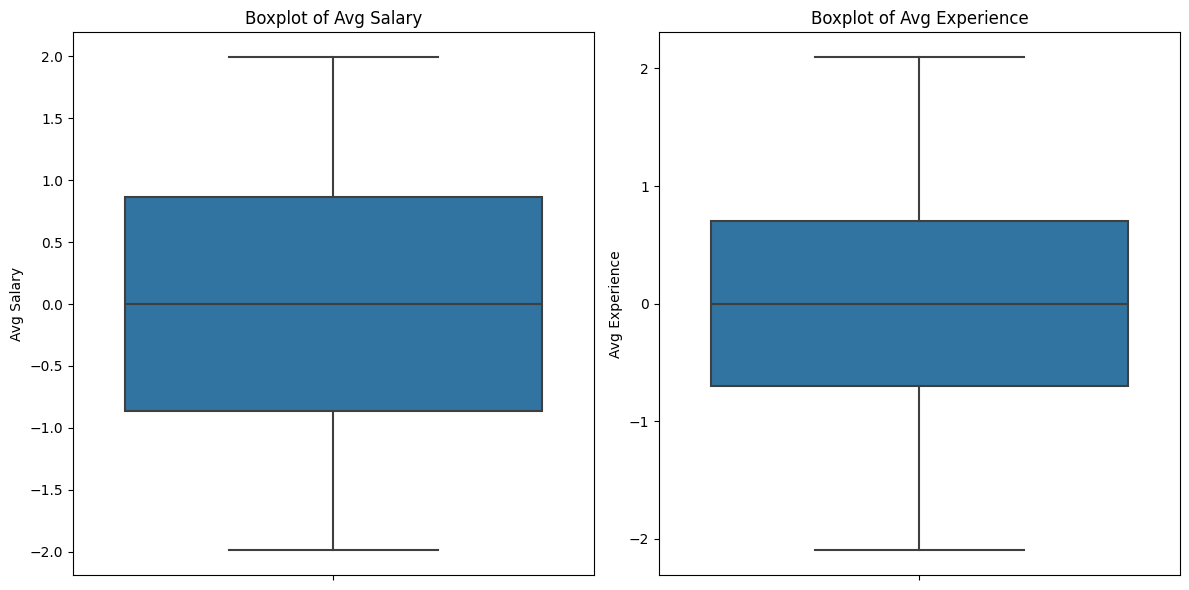

In [209]:
# Calculate Q1, Q3, and IQR for Avg Salary
Q1_salary = data['Avg Salary'].quantile(0.25)
Q3_salary = data['Avg Salary'].quantile(0.75)
IQR_salary = Q3_salary - Q1_salary

# Identify outliers
salary_outliers = data[(data['Avg Salary'] < (Q1_salary - 1.5 * IQR_salary)) | 
                              (data['Avg Salary'] > (Q3_salary + 1.5 * IQR_salary))]

# Calculate Q1, Q3, and IQR for Avg Experience
Q1_experience = data['Avg Experience'].quantile(0.25)
Q3_experience = data['Avg Experience'].quantile(0.75)
IQR_experience = Q3_experience - Q1_experience

# Identify outliers
experience_outliers = data[(data['Avg Experience'] < (Q1_experience - 1.5 * IQR_experience)) | 
                                  (data['Avg Experience'] > (Q3_experience + 1.5 * IQR_experience))]

print("Number of Salary Outliers:", len(salary_outliers))
print("Number of Experience Outliers:", len(experience_outliers))

# Set up the figure and axes
plt.figure(figsize=(12, 6))

# Create a boxplot for Avg Salary and Avg Experience
plt.subplot(1, 2, 1)
sns.boxplot(y=data['Avg Salary'])
plt.title('Boxplot of Avg Salary')
plt.subplot(1, 2, 2)
sns.boxplot(y=data['Avg Experience'])
plt.title('Boxplot of Avg Experience')

# Show the plot
plt.tight_layout()
plt.show()


Standardization for numerical feature like 'Company Size'

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
mmscaler = MinMaxScaler()

# Fit the scaler and transform the 'Company Size' column
data['Company Size'] = mmscaler.fit_transform(data['Company Size'].values.reshape(-1, 1))

# Save the fitted scaler
joblib.dump(mmscaler, 'minmax_scaler_company_size.pkl')

# Check the transformed values
print(data['Company Size'].head())


Manual mapping for 'qualificaitons'

In [22]:
# Display all unique qualifications
unique_qualifications = data['Qualifications'].unique()
print("Unique Qualifications:")
for qual in unique_qualifications:
    print(qual)

Unique Qualifications:
M.Tech
PhD
BCA
B.Com
BA
M.Com
B.Tech
BBA
MBA
MCA


In [23]:
# Group similar qualifications
# This step can be modified based on the similarity between qualifications.
data['Qualifications'] = data['Qualifications'].replace({
    "B.Tech": "Bachelor", "BCA": "Bachelor", "BBA": "Bachelor", "B.Com": "Bachelor", "BA": "Bachelor",
    "M.Tech": "Master", "MCA": "Master", "M.Com": "Master", "MBA": "Master",
    "PhD": "Doctorate"
})

In [24]:
print(data['Qualifications'].unique())


['Master' 'Doctorate' 'Bachelor']


One hot encoding for categorical feature 'Work Type', 'Preference', 'Job Title', 'Qualification'

In [25]:
# One-hot encode categorical features such as 'location', 'Work Type', 'Preference'
data = pd.get_dummies(data, columns=['Job Title','Qualifications','Work Type', 'Preference'], drop_first=False)

# # Check if any column is boolean, and convert it to integers (0 and 1)
boolean_columns = data.select_dtypes(include=['bool']).columns
data[boolean_columns] = data[boolean_columns].astype(int)

In [26]:
data.columns

Index(['Job Id', 'location', 'Country', 'latitude', 'longitude',
       'Company Size', 'Contact Person', 'Contact', 'Role', 'Job Portal',
       'Job Description', 'Benefits', 'Responsibilities', 'Company',
       'Company Profile', 'Year', 'Month', 'Day', 'Job Posting Date Ordinal',
       'Backend Development', 'Business Intelligence & Strategy',
       'Cloud Computing & Infrastructure', 'Collaboration & Communication',
       'Construction & Engineering', 'Data Management & Analytics',
       'Debugging & Troubleshooting', 'DevOps & Continuous Integration',
       'E-commerce & Platforms', 'Frontend Development',
       'Graphic Design & Adobe Suite', 'Healthcare & Industry Knowledge',
       'Machine Learning & AI', 'Mobile App Development',
       'Network Administration', 'Programming',
       'Project Management & Leadership',
       'Security & Vulnerability Management', 'Soft Skills & Problem Solving',
       'System Analysis & IT Support', 'Testing & Quality Assurance',
   

Data Understanding for 'Qualifications', 'Work Type' and 'Preference'.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the features you want to visualize
qualifications = ['Qualifications_Bachelor', 'Qualifications_Doctorate', 'Qualifications_Master']
work_types = ['Work Type_Contract', 'Work Type_Full-Time', 'Work Type_Intern', 
              'Work Type_Part-Time', 'Work Type_Temporary']
preferences = ['Preference_Both', 'Preference_Female', 'Preference_Male']

# Set up the figure for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Qualifications
sns.barplot(x=qualifications, y=data[qualifications].sum(), ax=axes[0], palette='Set2')
axes[0].set_title('Distribution of Qualifications', fontsize=16)
axes[0].set_ylabel('Number of Job Postings', fontsize=12)
axes[0].set_xlabel('Qualifications', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Plot for Work Types
sns.barplot(x=work_types, y=data[work_types].sum(), ax=axes[1], palette='Set2')
axes[1].set_title('Distribution of Work Types', fontsize=16)
axes[1].set_ylabel('Number of Job Postings', fontsize=12)
axes[1].set_xlabel('Work Types', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Plot for Preferences
sns.barplot(x=preferences, y=data[preferences].sum(), ax=axes[2], palette='Set2')
axes[2].set_title('Distribution of Preferences', fontsize=16)
axes[2].set_ylabel('Number of Job Postings', fontsize=12)
axes[2].set_xlabel('Preferences', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Feature Engineering: Drop unwanted columns

In [27]:
# Drop multiple columns
data = data.drop(
    columns=['Job Id','Country','Contact','latitude','longitude','Contact Person','Role','Benefits', 'Job Description',
              'Responsibilities','Company','Company Profile','Job Portal','location'])

# Print all column count
print("Column counts in the DataFrame:")
print(len(data.columns))

# Print all column names
print("Column names in the DataFrame:")
print(data.columns)

Column counts in the DataFrame:
67
Column names in the DataFrame:
Index(['Company Size', 'Year', 'Month', 'Day', 'Job Posting Date Ordinal',
       'Backend Development', 'Business Intelligence & Strategy',
       'Cloud Computing & Infrastructure', 'Collaboration & Communication',
       'Construction & Engineering', 'Data Management & Analytics',
       'Debugging & Troubleshooting', 'DevOps & Continuous Integration',
       'E-commerce & Platforms', 'Frontend Development',
       'Graphic Design & Adobe Suite', 'Healthcare & Industry Knowledge',
       'Machine Learning & AI', 'Mobile App Development',
       'Network Administration', 'Programming',
       'Project Management & Leadership',
       'Security & Vulnerability Management', 'Soft Skills & Problem Solving',
       'System Analysis & IT Support', 'Testing & Quality Assurance',
       'UI/UX & Design', 'Web Development', 'Avg Salary', 'Avg Experience',
       'Job Title_Back-End Developer', 'Job Title_Business Analyst',
   

In [28]:
data.head()

,Company Size,Year,Month,Day,Job Posting Date Ordinal,Backend Development,Business Intelligence & Strategy,Cloud Computing & Infrastructure,Collaboration & Communication,Construction & Engineering,...,Qualifications_Doctorate,Qualifications_Master,Work Type_Contract,Work Type_Full-Time,Work Type_Intern,Work Type_Part-Time,Work Type_Temporary,Preference_Both,Preference_Female,Preference_Male
0,0.001792,2021,10,1,738064,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
1,0.003617,2021,10,1,738064,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
2,0.004280,2021,10,1,738064,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.006973,2021,10,1,738064,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.008291,2021,10,1,738064,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,1


Data Understanding: Check if got class imbalance

In [64]:
# List of the 23 skills columns
skill_columns = ['Backend Development','Business Intelligence & Strategy','Cloud Computing & Infrastructure',
                 'Collaboration & Communication','Construction & Engineering','Data Management & Analytics',
                 'Debugging & Troubleshooting','DevOps & Continuous Integration','E-commerce & Platforms',
                 'Frontend Development','Graphic Design & Adobe Suite','Healthcare & Industry Knowledge',
                 'Machine Learning & AI','Mobile App Development','Network Administration','Programming',
                 'Project Management & Leadership','Security & Vulnerability Management','Soft Skills & Problem Solving',
                 'System Analysis & IT Support','Testing & Quality Assurance','UI/UX & Design','Web Development'
]

# Calculate the frequency of each skill
skill_frequencies = data[skill_columns].sum()

# Calculate the mean frequency across all skills
mean_threshold = skill_frequencies.mean()

print(f"Mean Frequency: {mean_threshold}")

skill_demand = pd.DataFrame({
    'Skill': skill_frequencies.index,
    'Frequency': skill_frequencies.values,
    'Demand': [1 if freq > mean_threshold else 0 for freq in skill_frequencies.values]
})

# Now skill_demand contains Skill, Frequency, and Demand ('1'= high demand or '0'= low demand)
print(skill_demand.head(24))

Mean Frequency: 37407.608695652176
                                  Skill  Frequency  Demand
0                   Backend Development      36517       0
1      Business Intelligence & Strategy      13284       0
2      Cloud Computing & Infrastructure      43561       1
3         Collaboration & Communication      46737       1
4            Construction & Engineering       6674       0
5           Data Management & Analytics      96257       1
6           Debugging & Troubleshooting      66793       1
7       DevOps & Continuous Integration      43184       1
8                E-commerce & Platforms       6691       0
9                  Frontend Development      43417       1
10         Graphic Design & Adobe Suite       6549       0
11      Healthcare & Industry Knowledge       3305       0
12                Machine Learning & AI      10016       0
13               Mobile App Development       6684       0
14               Network Administration      46994       1
15                   

In [66]:
pd.set_option('display.max_columns', None)
data.head()

,Company Size,Year,Month,Day,Job Posting Date Ordinal,Backend Development,Business Intelligence & Strategy,Cloud Computing & Infrastructure,Collaboration & Communication,Construction & Engineering,Data Management & Analytics,Debugging & Troubleshooting,DevOps & Continuous Integration,E-commerce & Platforms,Frontend Development,Graphic Design & Adobe Suite,Healthcare & Industry Knowledge,Machine Learning & AI,Mobile App Development,Network Administration,Programming,Project Management & Leadership,Security & Vulnerability Management,Soft Skills & Problem Solving,System Analysis & IT Support,Testing & Quality Assurance,UI/UX & Design,Web Development,Avg Salary,Avg Experience,Job Title_Back-End Developer,Job Title_Business Analyst,Job Title_Data Analyst,Job Title_Data Engineer,Job Title_Data Scientist,Job Title_Database Administrator,Job Title_Database Developer,Job Title_Front-End Developer,Job Title_Front-End Engineer,Job Title_IT Administrator,Job Title_IT Manager,Job Title_IT Support Specialist,Job Title_Java Developer,Job Title_Network Engineer,Job Title_Network Security Specialist,Job Title_Project Manager,Job Title_Software Developer,Job Title_Software Engineer,Job Title_Software Tester,Job Title_Systems Administrator,Job Title_Systems Analyst,Job Title_Systems Engineer,Job Title_UI Developer,Job Title_UX Researcher,Job Title_Web Designer,Job Title_Web Developer,Qualifications_Bachelor,Qualifications_Doctorate,Qualifications_Master,Work Type_Contract,Work Type_Full-Time,Work Type_Intern,Work Type_Part-Time,Work Type_Temporary,Preference_Both,Preference_Female,Preference_Male,Skill_Sum
0,0.001792,2021,10,1,738064,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.666910,-1.050350,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,2
1,0.003617,2021,10,1,738064,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.861273,1.048217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,3
2,0.004280,2021,10,1,738064,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-1.193487,-0.001067,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,5
3,0.006973,2021,10,1,738064,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.459258,0.348695,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1
4,0.008291,2021,10,1,738064,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.065567,-0.700589,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,2


Address Class Imbalance Issue

In [135]:
# Define minimum and maximum thresholds
min_threshold = 3000
max_threshold = data['Skill_Sum'].quantile(0.75)  # using the 75th percentile as a cap

# Create an empty DataFrame to store the adjusted data
resampled_data = pd.DataFrame()

for skill in skill_columns:
    skill_data = data[data[skill] == 1]
    # Ensure skill_data is a DataFrame (even if it's already a subset, this guarantees it's treated as such)
    skill_data = pd.DataFrame(skill_data)
    current_count = len(skill_data)
    # Calculate the target sample size within the defined thresholds
    target_count = max(min_threshold, min(max_threshold, current_count))
    if current_count > target_count:
        # Only sample down if above the target count
        skill_data = skill_data.sample(n=int(target_count), random_state=42)
    resampled_data = pd.concat([resampled_data, skill_data], axis=0, ignore_index=True)

# Remove duplicates since a single instance can belong to multiple skills
resampled_data = resampled_data.drop_duplicates()
# New distribution of skills
skill_counts_adjusted = resampled_data[skill_columns].sum()

print("Adjusted distribution of skill frequencies:")
print(skill_counts_adjusted.describe())
print(skill_counts_adjusted)

# Assuming 'resampled_data' is your DataFrame after undersampling
if 'Skill_Sum' in resampled_data.columns:
    resampled_data.drop('Skill_Sum', axis=1, inplace=True)

# Now, 'resampled_data' no longer contains the 'Skill_Sum' column
print(resampled_data.columns)  # To verify that the column has been successfully removed

Adjusted distribution of skill frequencies:
count       23.00000
mean      9618.73913
std       4501.33131
min       3000.00000
25%       4536.00000
50%       9981.00000
75%      12774.00000
max      18107.00000
dtype: float64
Backend Development                     9649
Business Intelligence & Strategy        4552
Cloud Computing & Infrastructure        9451
Collaboration & Communication          14537
Construction & Engineering              3907
Data Management & Analytics            18107
Debugging & Troubleshooting            13138
DevOps & Continuous Integration        11191
E-commerce & Platforms                  4520
Frontend Development                   11797
Graphic Design & Adobe Suite            3816
Healthcare & Industry Knowledge         3000
Machine Learning & AI                   3607
Mobile App Development                  4178
Network Administration                  9981
Programming                            13218
Project Management & Leadership         9796
Security

In [165]:
# Calculate the frequency of each skill
skill_frequencies = resampled_data[skill_columns].sum()

# Step 2: Calculate the mean frequency across all skills
mean_threshold = skill_frequencies.mean()

print(f"Mean Frequency: {mean_threshold}")

skill_demand = pd.DataFrame({
    'Skill': skill_frequencies.index,
    'Frequency': skill_frequencies.values,
    'Demand': [1 if freq > mean_threshold else 0 for freq in skill_frequencies.values]
})

# Now skill_demand contains Skill, Frequency, and Demand ('High' or 'Low')
print(skill_demand.head(23))


Mean Frequency: 9618.739130434782
                                  Skill  Frequency  Demand
0                   Backend Development       9649       1
1      Business Intelligence & Strategy       4552       0
2      Cloud Computing & Infrastructure       9451       0
3         Collaboration & Communication      14537       1
4            Construction & Engineering       3907       0
5           Data Management & Analytics      18107       1
6           Debugging & Troubleshooting      13138       1
7       DevOps & Continuous Integration      11191       1
8                E-commerce & Platforms       4520       0
9                  Frontend Development      11797       1
10         Graphic Design & Adobe Suite       3816       0
11      Healthcare & Industry Knowledge       3000       0
12                Machine Learning & AI       3607       0
13               Mobile App Development       4178       0
14               Network Administration       9981       1
15                    

Determine the features and targets first, train-test-split

In [138]:
# Strip any leading or trailing spaces from the column names of the DataFrame
resampled_data.columns = resampled_data.columns.str.strip()  # Strip any leading or trailing spaces

# List all columns from the DataFrame as potential targets
all_columns = list(resampled_data.columns)

# Define input features using pattern matching
features = [
    'Job Posting Date Ordinal','Year', 'Month','Day','Avg Salary', 'Avg Experience', 'Company Size'
] + [col for col in resampled_data.columns if col.startswith(('Job Title_', 'Qualifications_', 'Work Type_', 'Preference_'))]

# Use list comprehension to define targets by excluding input features from all columns
targets = [col for col in all_columns if col not in features]

# Print features and targets to verify
print("Features:")
print(features)
print(len(features))
print("\nTargets:")
print(targets)
print(len(targets))


Features:
['Job Posting Date Ordinal', 'Year', 'Month', 'Day', 'Avg Salary', 'Avg Experience', 'Company Size', 'Job Title_Back-End Developer', 'Job Title_Business Analyst', 'Job Title_Data Analyst', 'Job Title_Data Engineer', 'Job Title_Data Scientist', 'Job Title_Database Administrator', 'Job Title_Database Developer', 'Job Title_Front-End Developer', 'Job Title_Front-End Engineer', 'Job Title_IT Administrator', 'Job Title_IT Manager', 'Job Title_IT Support Specialist', 'Job Title_Java Developer', 'Job Title_Network Engineer', 'Job Title_Network Security Specialist', 'Job Title_Project Manager', 'Job Title_Software Developer', 'Job Title_Software Engineer', 'Job Title_Software Tester', 'Job Title_Systems Administrator', 'Job Title_Systems Analyst', 'Job Title_Systems Engineer', 'Job Title_UI Developer', 'Job Title_UX Researcher', 'Job Title_Web Designer', 'Job Title_Web Developer', 'Qualifications_Bachelor', 'Qualifications_Doctorate', 'Qualifications_Master', 'Work Type_Contract', 'W

In [139]:
# Initial size
print("Original DataFrame size:", data.shape[0])

# Sampling logic (assuming it has been run as per your description)

# Final size
print("Undersampled DataFrame size:", resampled_data.shape[0])

# Percentage reduction
reduction_percentage = ((data.shape[0] - resampled_data.shape[0]) / data.shape[0]) * 100
print(f"Reduction in rows: {reduction_percentage:.2f}%")

# Detailed class distribution comparison
print("Class distribution before sampling (Example skill):")
print(data['Backend Development'].value_counts())  # Replace 'Skill_Name' with an actual skill column name

print("Class distribution after sampling (Example skill):")
print(resampled_data['Backend Development'].value_counts())  # Ensure 'Skill_Name' is in final_sampled_df

Original DataFrame size: 280066
Undersampled DataFrame size: 61811
Reduction in rows: 77.93%
Class distribution before sampling (Example skill):
Backend Development
0    243549
1     36517
Name: count, dtype: int64
Class distribution after sampling (Example skill):
Backend Development
0    52162
1     9649
Name: count, dtype: int64


In [191]:
from sklearn.model_selection import train_test_split

# Assuming final_sampled_df is your DataFrame after preprocessing and features and targets have been defined
X = resampled_data[features]  # Input features
Y = resampled_data[targets]   # Target variables

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Verify the shapes of the datasets
print("Training set shape:", X_train.shape, Y_train.shape)
print("Test set shape:", X_test.shape, Y_test.shape)


Training set shape: (49448, 44) (49448, 23)
Test set shape: (12363, 44) (12363, 23)


In [ ]:
resampled_data.to_csv('preprocessed_data.csv', index=False)  # Save as CSV

In [195]:
resampled_data.head()

,Company Size,Year,Month,Day,Job Posting Date Ordinal,Backend Development,Business Intelligence & Strategy,Cloud Computing & Infrastructure,Collaboration & Communication,Construction & Engineering,Data Management & Analytics,Debugging & Troubleshooting,DevOps & Continuous Integration,E-commerce & Platforms,Frontend Development,Graphic Design & Adobe Suite,Healthcare & Industry Knowledge,Machine Learning & AI,Mobile App Development,Network Administration,Programming,Project Management & Leadership,Security & Vulnerability Management,Soft Skills & Problem Solving,System Analysis & IT Support,Testing & Quality Assurance,UI/UX & Design,Web Development,Avg Salary,Avg Experience,Job Title_Back-End Developer,Job Title_Business Analyst,Job Title_Data Analyst,Job Title_Data Engineer,Job Title_Data Scientist,Job Title_Database Administrator,Job Title_Database Developer,Job Title_Front-End Developer,Job Title_Front-End Engineer,Job Title_IT Administrator,Job Title_IT Manager,Job Title_IT Support Specialist,Job Title_Java Developer,Job Title_Network Engineer,Job Title_Network Security Specialist,Job Title_Project Manager,Job Title_Software Developer,Job Title_Software Engineer,Job Title_Software Tester,Job Title_Systems Administrator,Job Title_Systems Analyst,Job Title_Systems Engineer,Job Title_UI Developer,Job Title_UX Researcher,Job Title_Web Designer,Job Title_Web Developer,Qualifications_Bachelor,Qualifications_Doctorate,Qualifications_Master,Work Type_Contract,Work Type_Full-Time,Work Type_Intern,Work Type_Part-Time,Work Type_Temporary,Preference_Both,Preference_Female,Preference_Male
0,0.036911,2022,11,14,738473,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.063960,-1.400111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0
1,0.315999,2022,3,2,738216,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-0.861273,-0.001067,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
2,0.854764,2023,2,26,738577,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.331338,-0.700589,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0
3,0.487343,2022,11,28,738487,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.063960,2.097500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
4,0.855336,2023,8,14,738746,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0.268254,0.348695,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0


Data Understanding based of the preprocessed dataframe

Skill Distribution Across Job Titles

In [ ]:
# List of skill columns
skill_columns = ['Backend Development','Business Intelligence & Strategy','Cloud Computing & Infrastructure',
                 'Collaboration & Communication','Construction & Engineering','Data Management & Analytics',
                 'Debugging & Troubleshooting','DevOps & Continuous Integration','E-commerce & Platforms',
                 'Frontend Development','Graphic Design & Adobe Suite','Healthcare & Industry Knowledge',
                 'Machine Learning & AI','Mobile App Development','Network Administration','Programming',
                 'Project Management & Leadership','Security & Vulnerability Management','Soft Skills & Problem Solving',
                 'System Analysis & IT Support','Testing & Quality Assurance','UI/UX & Design','Web Development'
]

# Extract all one-hot encoded 'Job Title' columns
job_title_columns = [col for col in data.columns if col.startswith('Job Title_')]

# Initialize an empty DataFrame to store aggregated skill data by job title
job_skill_distribution = pd.DataFrame()

# For each job title, calculate the sum of skills when that job title is present
for job in job_title_columns:
    # Multiply the job title column with the skill columns to get the relevant skills for that job
    job_skills = data[skill_columns].multiply(data[job], axis=0)
    # Sum the skills for this job title and store it in the new DataFrame
    job_skill_distribution[job] = job_skills.sum()

# Transpose the DataFrame for easier plotting (jobs as rows, skills as columns)
job_skill_distribution = job_skill_distribution.T

# Plotting the stacked bar chart for skill distribution by job title
plt.figure(figsize=(16, 10))  # Increase figure size
job_skill_distribution.plot(kind='bar', stacked=True, colormap='tab20', width=0.8, figsize=(16, 10))

# Reduce the legend font size and move it outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title="Skills")

# Add title and labels
plt.title('Skill Distribution Across Job Titles', fontsize=18)
plt.xlabel('Job Titles', fontsize=14)
plt.ylabel('Number of Skills', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adjust the layout to ensure everything fits
plt.tight_layout()

# Display the plot
plt.show()

Predict Skill Combinations - Skill Combinations Analysis

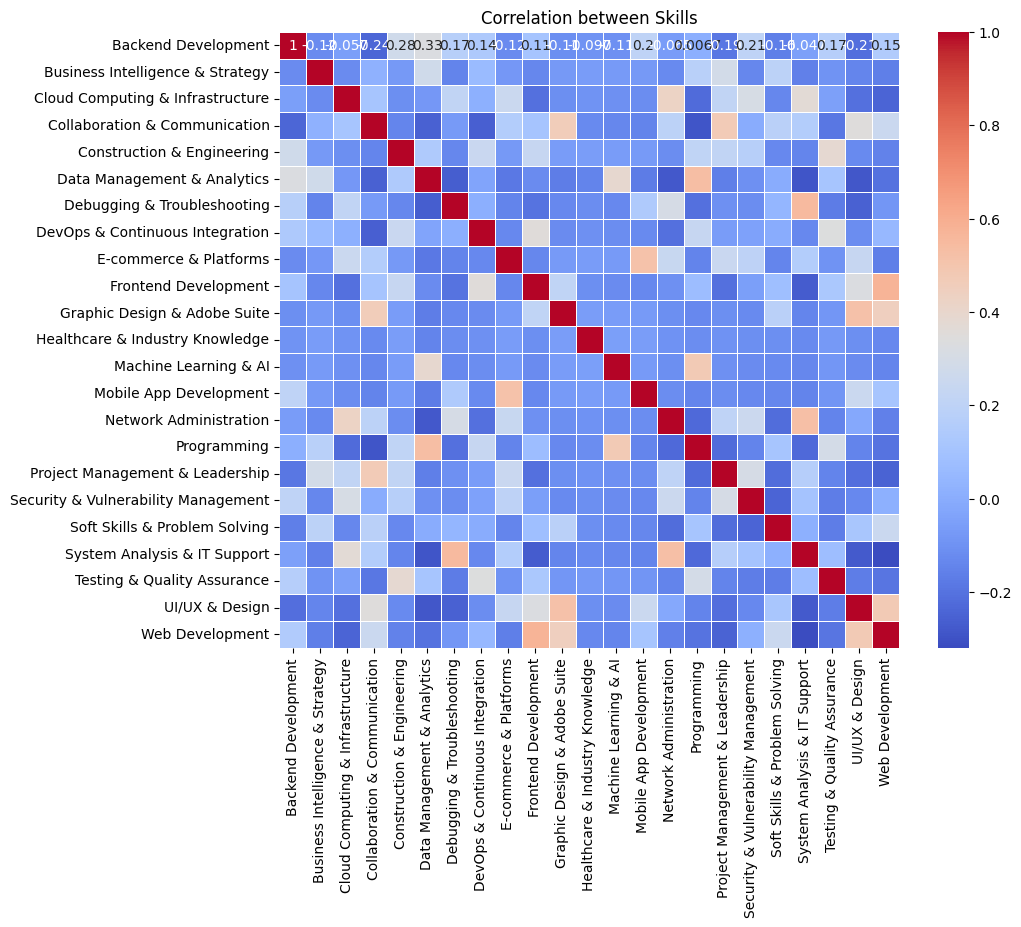

In [223]:
# Correlation matrix between different skills
skill_correlation = resampled_data[targets].corr()

# Plot heatmap of skill combinations (correlation matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(skill_correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation between Skills', fontsize=16)
plt.tight_layout()
plt.show()


Data Modelling:

Train Random Forest Classifier to get Feature Importance

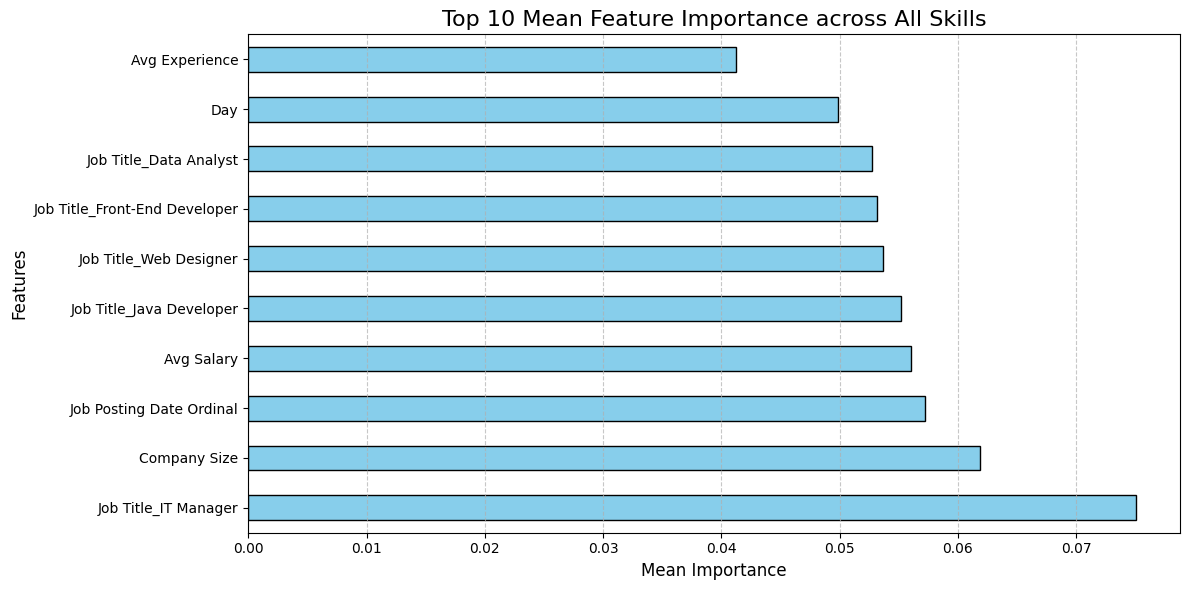

In [197]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a dictionary to store feature importance for each target
feature_importances = {}

# Train a RandomForest for each skill (multi-label)
for target in targets:
    # Train a random forest for each skill (target)
    rf = RandomForestClassifier(random_state=42)
    rf.fit(resampled_data[features], resampled_data[target])
    # Store the feature importance for each target skill
    feature_importances[target] = rf.feature_importances_

# Convert to a DataFrame for better visualization
importances_df = pd.DataFrame(feature_importances, index=features)
# Calculate mean feature importance across all skills
mean_importance = importances_df.mean(axis=1)
# Get the top 10 features
top_10_features = mean_importance.sort_values(ascending=False).head(10)

# Plot the feature importance
plt.figure(figsize=(12, 6))
top_10_features.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 10 Mean Feature Importance across All Skills', fontsize=16)
plt.xlabel('Mean Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.tight_layout()
plt.show()

Random Forest Base Model

In [188]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train the multi-output model
model = MultiOutputClassifier(RandomForestClassifier())
model.fit(X_train, Y_train)

# Make predictions
y_pred = model.predict(X_test)

# Initialize a dictionary to store results
rf_results = {}

# Evaluate the model for each target skill
for i, target in enumerate(targets):
    accuracy = accuracy_score(Y_test.iloc[:, i], y_pred[:, i])
    rf_results[target] = {
        'Accuracy': accuracy
    }
    print(f"Accuracy for {target}: {accuracy}")

# Get classification report for each target skill
rf_report = classification_report(Y_test, y_pred, target_names=targets, output_dict=True)

# Store precision, recall, and F1-score in the results dictionary
for target in targets:
    rf_results[target].update({
        'Precision': rf_report[target]['precision'],
        'Recall': rf_report[target]['recall'],
        'F1-Score': rf_report[target]['f1-score']
    })

Accuracy for Backend Development: 0.9075467119631158
Accuracy for Business Intelligence & Strategy: 0.9369894038663755
Accuracy for Cloud Computing & Infrastructure: 0.9324597589581817
Accuracy for Collaboration & Communication: 0.8837660761950983
Accuracy for Construction & Engineering: 0.9377982690285529
Accuracy for Data Management & Analytics: 0.8568308662945887
Accuracy for Debugging & Troubleshooting: 0.8810968211599126
Accuracy for DevOps & Continuous Integration: 0.9264741567580684
Accuracy for E-commerce & Platforms: 0.9454824880692388
Accuracy for Frontend Development: 0.8721184178597428
Accuracy for Graphic Design & Adobe Suite: 0.9362614252204158
Accuracy for Healthcare & Industry Knowledge: 0.9734692226805791
Accuracy for Machine Learning & AI: 0.9602038340208687
Accuracy for Mobile App Development: 0.9674027339642481
Accuracy for Network Administration: 0.9623068834425301
Accuracy for Programming: 0.9455633745854566
Accuracy for Project Management & Leadership: 0.96352018

c:\Users\Joshuaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest Classifier - Hyperparameter Tuning

In [93]:
from sklearn.model_selection import GridSearchCV

# Define the base RandomForest model and wrap the model for multi-output classification
rf_model = RandomForestClassifier(random_state=42)
multi_rf_model = MultiOutputClassifier(rf_model, n_jobs=-1)

# Define hyperparameter grid
rf_param_grid = {
    'estimator__n_estimators': [100, 200],  # Note the 'estimator__' prefix for wrapped models
    'estimator__max_depth': [10, 20, None],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2],
    'estimator__max_features': ['sqrt', 'log2']
}

# GridSearchCV with multi-output model
rf_grid_search = GridSearchCV(estimator=multi_rf_model, param_grid=rf_param_grid, cv=3, n_jobs=2, verbose=2, scoring='accuracy')

# Fit the grid search
rf_grid_search.fit(X_train, Y_train)

# Print best hyperparameters and accuracy
print(f"Best Random Forest Hyperparameters: {rf_grid_search.best_params_}")
print(f"Best Random Forest Accuracy: {rf_grid_search.best_score_}")

# Use the best model found by GridSearchCV
best_rf_model = rf_grid_search.best_estimator_

# Predict on the test data
y_pred_best = best_rf_model.predict(X_test)

# Initialize a dictionary to store results after tuning
rf_results_hp = {}

# Calculate accuracy for each skill after tuning and store results
for idx, skill in enumerate(Y_test.columns):
    acc = accuracy_score(Y_test.iloc[:, idx], y_pred_best[:, idx])
    rf_results_hp[skill] = {
        'Accuracy': acc,
    }
    print(f"Accuracy for {skill} after tuning: {acc}")

# Optionally, store precision, recall, and F1-score after tuning
rf_report_hp = classification_report(Y_test, y_pred_best, target_names=Y_test.columns, output_dict=True)

for skill in Y_test.columns:
    rf_results_hp[skill].update({
        'Precision': rf_report_hp[skill]['precision'],
        'Recall': rf_report_hp[skill]['recall'],
        'F1-Score': rf_report_hp[skill]['f1-score']
    })

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Random Forest Hyperparameters: {'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}
Best Random Forest Accuracy: 0.45016991505583376
Accuracy for Backend Development after tuning: 0.9096497613847772
Accuracy for Business Intelligence & Strategy after tuning: 0.9385262476745126
Accuracy for Cloud Computing & Infrastructure after tuning: 0.9340774892825366
Accuracy for Collaboration & Communication after tuning: 0.8853029200032355
Accuracy for Construction & Engineering after tuning: 0.9387689072231659
Accuracy for Data Management & Analytics after tuning: 0.8586912561675969
Accuracy for Debugging & Troubleshooting after tuning: 0.8845749413572758
Accuracy for DevOps & Continuous Integration after tuning: 0.9290625252770364
Accuracy for E-commerce & Platforms after tuning: 0.9479090835557713
Accuracy for Front

c:\Users\Joshuaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [198]:
# After training your base Random Forest model
joblib.dump(rf_model, 'random_forest_base_model.pkl')

# After training your tuned Random Forest model
joblib.dump(best_rf_model, 'random_forest_tuned_model.pkl')

['random_forest_tuned_model.pkl']

In [227]:
rf_results_df = pd.DataFrame.from_dict(rf_results, orient='index')

# Optionally round the decimal points for better visualization
rf_results_df = rf_results_df.round(4)

print("\nModel Evaluation Results:")
print(rf_results_df)

# Save results_df to a CSV file for further analysis
rf_results_df.to_csv('random_forest_base_model_results.csv', index=True)


Model Evaluation Results:
                                     Accuracy  Precision  Recall  F1-Score
Backend Development                    0.9075     0.7381  0.6433    0.6874
Business Intelligence & Strategy       0.9370     0.5760  0.3527    0.4375
Cloud Computing & Infrastructure       0.9325     0.8280  0.6982    0.7576
Collaboration & Communication          0.8838     0.7928  0.6846    0.7347
Construction & Engineering             0.9378     0.5372  0.4739    0.5036
Data Management & Analytics            0.8568     0.8063  0.6704    0.7321
Debugging & Troubleshooting            0.8811     0.7700  0.6091    0.6802
DevOps & Continuous Integration        0.9265     0.7701  0.8357    0.8016
E-commerce & Platforms                 0.9455     0.6156  0.6663    0.6400
Frontend Development                   0.8721     0.7347  0.5469    0.6270
Graphic Design & Adobe Suite           0.9363     0.4813  0.3520    0.4066
Healthcare & Industry Knowledge        0.9735     0.6762  0.8447    0.751

In [98]:
# Convert the dictionary into a DataFrame for better readability
rf_results_hp = pd.DataFrame(rf_results_hp).transpose()

# Optionally round the decimal points for better visualization
rf_results_hp = rf_results_hp.round(4)

# Print the DataFrame to see the classification report in table format
print(rf_results_hp)

rf_results_hp.to_csv('random_forest_evaluation_results_after_tuning.csv')

                                     precision  recall  f1-score  support
Backend Development                     0.7244  0.6914    0.7075   1954.0
Business Intelligence & Strategy        0.5895  0.3795    0.4618    859.0
Cloud Computing & Infrastructure        0.8198  0.7228    0.7683   1869.0
Collaboration & Communication           0.7765  0.7193    0.7468   2907.0
Construction & Engineering              0.5358  0.6002    0.5662    823.0
Data Management & Analytics             0.8023  0.6842    0.7386   3607.0
Debugging & Troubleshooting             0.7657  0.6395    0.6970   2566.0
DevOps & Continuous Integration         0.7619  0.8739    0.8141   2197.0
E-commerce & Platforms                  0.6085  0.7953    0.6895    899.0
Frontend Development                    0.7258  0.5436    0.6216   2430.0
Graphic Design & Adobe Suite            0.4849  0.4407    0.4617    767.0
Healthcare & Industry Knowledge         0.6844  0.9437    0.7934    586.0
Machine Learning & AI                 

Logistic Regression Base Model

In [106]:
from sklearn.linear_model import LogisticRegression
# Initialize the Logistic Regression model
logistic_regression_model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42, class_weight='balanced')
multi_logistic_model = MultiOutputClassifier(logistic_regression_model, n_jobs=-1)

# Fit the multi-output Logistic Regression model
multi_logistic_model.fit(X_train, Y_train)

# Make predictions
y_pred = multi_logistic_model.predict(X_test)

# Initialize a dictionary to store results
logistic_results = {}

# Evaluate the model for each target skill
for i, target in enumerate(targets):
    accuracy = accuracy_score(Y_test.iloc[:, i], y_pred[:, i])
    logistic_results[target] = {
        'Accuracy': accuracy
    }
    print(f"Accuracy for {target}: {accuracy}")

# Get classification report for each target skill
logistic_report = classification_report(Y_test, y_pred, target_names=targets, output_dict=True)

# Store precision, recall, and F1-score in the results dictionary
for target in targets:
    logistic_results[target].update({
        'Precision': logistic_report[target]['precision'],
        'Recall': logistic_report[target]['recall'],
        'F1-Score': logistic_report[target]['f1-score']
    })


Accuracy for Backend Development: 0.8980829895656394
Accuracy for Business Intelligence & Strategy: 0.8932297985925746
Accuracy for Cloud Computing & Infrastructure: 0.8747876728949284
Accuracy for Collaboration & Communication: 0.8470435978322414
Accuracy for Construction & Engineering: 0.9445118498746259
Accuracy for Data Management & Analytics: 0.8182479980587236
Accuracy for Debugging & Troubleshooting: 0.8115344172126506
Accuracy for DevOps & Continuous Integration: 0.9215400792687859
Accuracy for E-commerce & Platforms: 0.952438728463965
Accuracy for Frontend Development: 0.827064628326458
Accuracy for Graphic Design & Adobe Suite: 0.9331877376041414
Accuracy for Healthcare & Industry Knowledge: 0.9772708889428132
Accuracy for Machine Learning & AI: 0.9577772385343363
Accuracy for Mobile App Development: 0.9686160317075143
Accuracy for Network Administration: 0.9596376284073445
Accuracy for Programming: 0.9335921701852301
Accuracy for Project Management & Leadership: 0.9324597589

Logistic Regression - Hyperparameter Tuning

In [108]:
from sklearn.pipeline import Pipeline

# Create a pipeline to standardize the data and then apply logistic regression
logistic_model = Pipeline([
    ('classifier', MultiOutputClassifier(LogisticRegression(solver='lbfgs', max_iter=5000)))
])

# Define the parameter grid with larger max_iter and different solvers
param_grid_logistic = {
    'classifier__estimator__C': [0.1, 1, 10],
    'classifier__estimator__penalty': ['l2'],
    'classifier__estimator__solver': ['lbfgs', 'saga', 'liblinear'],
    'classifier__estimator__max_iter': [1000, 2000, 5000, 10000]
}

# Perform Grid Search
grid_search_logistic = GridSearchCV(logistic_model, param_grid_logistic, cv=3, n_jobs=-1, verbose=2)
grid_search_logistic.fit(X_train, Y_train)

# Print the best parameters and best accuracy
print("Best Logistic Regression Hyperparameters:", grid_search_logistic.best_params_)
print("Best Logistic Regression Accuracy:", grid_search_logistic.best_score_)

# Use the best model found by GridSearchCV
best_lr_model = grid_search_logistic.best_estimator_

# Get predictions from the tuned model
y_pred_logistic = grid_search_logistic.predict(X_test)

# Initialize a dictionary to store results
logistic_results_hp = {}

# Evaluate the model for each target skill
print("\nAccuracy for each skill after tuning:")
for i, target in enumerate(Y_train.columns):
    accuracy = accuracy_score(Y_test.iloc[:, i], y_pred_logistic[:, i])
    logistic_results_hp[target] = {
        'Accuracy': accuracy
    }
    print(f"Accuracy for {target}: {accuracy}")

# Get the classification report for each target
logistic_report_hp = classification_report(Y_test, y_pred_logistic, target_names=Y_train.columns, output_dict=True)

# Store precision, recall, and F1-score in the results dictionary
for target in Y_train.columns:
    logistic_results_hp[target].update({
        'Precision': logistic_report_hp[target]['precision'],
        'Recall': logistic_report_hp[target]['recall'],
        'F1-Score': logistic_report_hp[target]['f1-score']
    })



Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Logistic Regression Hyperparameters: {'classifier__estimator__C': 1, 'classifier__estimator__max_iter': 5000, 'classifier__estimator__penalty': 'l2', 'classifier__estimator__solver': 'lbfgs'}
Best Logistic Regression Accuracy: 0.39959141757701966

Accuracy for each skill after tuning:
Accuracy for Backend Development: 0.9159589096497613
Accuracy for Business Intelligence & Strategy: 0.9421661409043113
Accuracy for Cloud Computing & Infrastructure: 0.9351290139933673
Accuracy for Collaboration & Communication: 0.8860308986491952
Accuracy for Construction & Engineering: 0.9427323465178354
Accuracy for Data Management & Analytics: 0.8655666100461054
Accuracy for Debugging & Troubleshooting: 0.8867588772951549
Accuracy for DevOps & Continuous Integration: 0.9333495106365769
Accuracy for E-commerce & Platforms: 0.952438728463965
Accuracy for Frontend Development: 0.8738979212165332
Accuracy for Graphic Design & Adobe Suite: 

c:\Users\Joshuaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [110]:
# After training your base Logistic Regression model
joblib.dump(multi_logistic_model, 'logistic_regression_base_model.pkl')

# After training your tuned Logistic Regression model
joblib.dump(best_lr_model, 'logistic_regression_tuned_model.pkl')

['logistic_regression_tuned_model.pkl']

In [111]:
# Convert the results dictionary into a DataFrame
logistic_results_df = pd.DataFrame.from_dict(logistic_results, orient='index')

# Optionally round the decimal points for better visualization
logistic_results_df = logistic_results_df.round(4)

# Print the results DataFrame
print("\nModel Evaluation Results:")
print(logistic_results_df)

# Save the results DataFrame to a CSV file for further analysis
logistic_results_df.to_csv('logistic_model_evaluation_results.csv', index=True)


Model Evaluation Results:
                                     Accuracy  Precision  Recall  F1-Score
Backend Development                    0.8981     0.6080  1.0000    0.7562
Business Intelligence & Strategy       0.8932     0.3942  1.0000    0.5655
Cloud Computing & Infrastructure       0.8748     0.5471  0.9984    0.7068
Collaboration & Communication          0.8470     0.6059  0.9997    0.7545
Construction & Engineering             0.9445     0.5454  1.0000    0.7058
Data Management & Analytics            0.8182     0.6193  0.9787    0.7586
Debugging & Troubleshooting            0.8115     0.5265  0.9150    0.6684
DevOps & Continuous Integration        0.9215     0.6937  1.0000    0.8192
E-commerce & Platforms                 0.9524     0.6046  1.0000    0.7536
Frontend Development                   0.8271     0.5320  1.0000    0.6945
Graphic Design & Adobe Suite           0.9332     0.4815  1.0000    0.6500
Healthcare & Industry Knowledge        0.9773     0.6759  1.0000    0.806

In [201]:
# Convert the dictionary into a DataFrame for better readability
logistic_results_hp = pd.DataFrame(logistic_results_hp).transpose()

# Optionally round the decimal points for better visualization
logistic_results_hp = logistic_results_hp.round(4)

# Print the DataFrame to see the classification report in table format
print(logistic_results_hp)

logistic_results_hp.to_csv('logistic_model_evaluation_results_after_tuning.csv')


Accuracy for each skill using the loaded model:
Accuracy for Backend Development: 0.9159589096497613
Accuracy for Business Intelligence & Strategy: 0.9421661409043113
Accuracy for Cloud Computing & Infrastructure: 0.9351290139933673
Accuracy for Collaboration & Communication: 0.8860308986491952
Accuracy for Construction & Engineering: 0.9427323465178354
Accuracy for Data Management & Analytics: 0.8655666100461054
Accuracy for Debugging & Troubleshooting: 0.8867588772951549
Accuracy for DevOps & Continuous Integration: 0.9333495106365769
Accuracy for E-commerce & Platforms: 0.952438728463965
Accuracy for Frontend Development: 0.8738979212165332
Accuracy for Graphic Design & Adobe Suite: 0.9373938364474642
Accuracy for Healthcare & Industry Knowledge: 0.9772708889428132
Accuracy for Machine Learning & AI: 0.9575345789856831
Accuracy for Mobile App Development: 0.9669983013831595
Accuracy for Network Administration: 0.9652996845425867
Accuracy for Programming: 0.9526813880126183
Accuracy

c:\Users\Joshuaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBoost (Extreme Gradient Boosting) Base Model

In [115]:
from xgboost import XGBClassifier

# Initialize the XGBoost Classifier
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
multi_xgboost_model = MultiOutputClassifier(xgboost_model, n_jobs=-1)

# Fit the model
multi_xgboost_model.fit(X_train, Y_train)

# Predict
y_pred = multi_xgboost_model.predict(X_test)

print("XGBoost Model:")

# Initialize a dictionary to store results
xgboost_results = {}

# Calculate accuracy for each skill
for idx, skill in enumerate(Y_test.columns):
    acc = accuracy_score(Y_test.iloc[:, idx], y_pred[:, idx])
    xgboost_results[skill] = {
        'Accuracy': acc
    }
    print(f"Accuracy for {skill}: {acc}")

# Get the classification report for each target skill
xgboost_report = classification_report(Y_test, y_pred, target_names=Y_test.columns, output_dict=True)

# Store precision, recall, and F1-score in the results dictionary
for skill in Y_test.columns:
    xgboost_results[skill].update({
        'Precision': xgboost_report[skill]['precision'],
        'Recall': xgboost_report[skill]['recall'],
        'F1-Score': xgboost_report[skill]['f1-score']
    })

XGBoost Model:
Accuracy for Backend Development: 0.9104586265469546
Accuracy for Business Intelligence & Strategy: 0.9364231982528513
Accuracy for Cloud Computing & Infrastructure: 0.9295478443743428
Accuracy for Collaboration & Communication: 0.8850602604545822
Accuracy for Construction & Engineering: 0.9386071341907304
Accuracy for Data Management & Analytics: 0.860228099975734
Accuracy for Debugging & Troubleshooting: 0.8852220334870177
Accuracy for DevOps & Continuous Integration: 0.9259888376607619
Accuracy for E-commerce & Platforms: 0.9471811049098116
Accuracy for Frontend Development: 0.8719566448273073
Accuracy for Graphic Design & Adobe Suite: 0.9356143330906738
Accuracy for Healthcare & Industry Knowledge: 0.9733883361643614
Accuracy for Machine Learning & AI: 0.9572919194370298
Accuracy for Mobile App Development: 0.9676453935129014
Accuracy for Network Administration: 0.9612553587316994
Accuracy for Programming: 0.9446736229070614
Accuracy for Project Management & Leadersh

c:\Users\Joshuaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBoost (Extreme Gradient Boosting) - Hyperparameter Tuning

In [116]:
# Create a pipeline for XGBoost
xgb_model = Pipeline([
    ('classifier', MultiOutputClassifier(XGBClassifier(use_label_encoder=False, eval_metric='logloss')))
])

# Define the parameter grid for hyperparameter tuning
param_grid_xgb = {
    'classifier__estimator__n_estimators': [100, 200, 300],  # Number of boosting rounds
    'classifier__estimator__max_depth': [3, 6, 9],           # Maximum depth of the tree
    'classifier__estimator__learning_rate': [0.01, 0.1, 0.2],# Learning rate
    'classifier__estimator__subsample': [0.8, 1.0],          # Subsample ratio
    'classifier__estimator__colsample_bytree': [0.8, 1.0],   # Subsample ratio of columns
}

# Perform Grid Search with 3-fold cross-validation
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, Y_train)

# Print the best parameters and best accuracy
print("Best XGBoost Hyperparameters:", grid_search_xgb.best_params_)
print("Best XGBoost Accuracy:", grid_search_xgb.best_score_)

# Use the best model found by GridSearchCV
best_xgboost_model =grid_search_xgb.best_estimator_

# Get predictions from the tuned model
y_pred_xgb = grid_search_xgb.predict(X_test)

# Initialize a dictionary to store results
xgb_results_hp = {}

# Calculate accuracy for each skill
print("\nAccuracy for each skill after tuning:")
for idx, skill in enumerate(Y_train.columns):
    acc = accuracy_score(Y_test.iloc[:, idx], y_pred_xgb[:, idx])
    xgb_results_hp[skill] = {
        'Accuracy': acc
    }
    print(f"Accuracy for {skill} after tuning: {acc}")

# Get the classification report for each target skill
xgb_report_hp = classification_report(Y_test, y_pred_xgb, target_names=Y_train.columns, output_dict=True)

# Store precision, recall, and F1-score in the results dictionary
for skill in Y_train.columns:
    xgb_results_hp[skill].update({
        'Precision': xgb_report_hp[skill]['precision'],
        'Recall': xgb_report_hp[skill]['recall'],
        'F1-Score': xgb_report_hp[skill]['f1-score']
    })

Fitting 3 folds for each of 108 candidates, totalling 324 fits


c:\Users\Joshuaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:47:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Joshuaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:47:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Joshuaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder"

Best XGBoost Hyperparameters: {'classifier__estimator__colsample_bytree': 0.8, 'classifier__estimator__learning_rate': 0.1, 'classifier__estimator__max_depth': 3, 'classifier__estimator__n_estimators': 300, 'classifier__estimator__subsample': 1.0}
Best XGBoost Accuracy: 0.423273011236416

Accuracy for each skill after tuning:
Accuracy for Backend Development after tuning: 0.9162824557146324
Accuracy for Business Intelligence & Strategy after tuning: 0.9420852543880935
Accuracy for Cloud Computing & Infrastructure after tuning: 0.9335112836690124
Accuracy for Collaboration & Communication after tuning: 0.8884574941357276
Accuracy for Construction & Engineering after tuning: 0.940629297096174
Accuracy for Data Management & Analytics after tuning: 0.866941680821807
Accuracy for Debugging & Troubleshooting after tuning: 0.889266359297905
Accuracy for DevOps & Continuous Integration after tuning: 0.9339157162501011
Accuracy for E-commerce & Platforms after tuning: 0.9507401116233923
Accurac

c:\Users\Joshuaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [117]:
# After training your base XGBoost model
joblib.dump(multi_xgboost_model, 'xgboost_base_model.pkl')

# After training your tuned XGBoost model
joblib.dump(best_xgboost_model, 'xgboost_tuned_model.pkl')

['xgboost_tuned_model.pkl']

In [118]:
# Convert the results dictionary into a DataFrame
xgboost_results_df = pd.DataFrame.from_dict(xgboost_results, orient='index')

# Optionally round the decimal points for better visualization
xgboost_results_df = xgboost_results_df.round(4)

# Print the results DataFrame
print("\nModel Evaluation Results:")
print(xgboost_results_df)

# Save the results DataFrame to a CSV file for further analysis
xgboost_results_df.to_csv('xgboost_model_evaluation_results.csv', index=True)


Model Evaluation Results:
                                     Accuracy  Precision  Recall  F1-Score
Backend Development                    0.9105     0.7259  0.6965    0.7109
Business Intelligence & Strategy       0.9364     0.5561  0.4214    0.4795
Cloud Computing & Infrastructure       0.9295     0.8024  0.7084    0.7525
Collaboration & Communication          0.8851     0.7819  0.7090    0.7436
Construction & Engineering             0.9386     0.5369  0.5662    0.5512
Data Management & Analytics            0.8602     0.7997  0.6950    0.7437
Debugging & Troubleshooting            0.8852     0.7639  0.6469    0.7006
DevOps & Continuous Integration        0.9260     0.7612  0.8503    0.8033
E-commerce & Platforms                 0.9472     0.6152  0.7308    0.6680
Frontend Development                   0.8720     0.7359  0.5436    0.6253
Graphic Design & Adobe Suite           0.9356     0.4794  0.4394    0.4585
Healthcare & Industry Knowledge        0.9734     0.6833  0.8174    0.744

In [119]:

# Convert the results dictionary into a DataFrame
xgb_results_hp = pd.DataFrame.from_dict(xgb_results_hp, orient='index')

# Optionally round the decimal points for better visualization
xgb_results_hp = xgb_results_hp.round(4)

# Print the results DataFrame
print("\nModel Evaluation Results:")
print(xgb_results_hp)

# Save the results DataFrame to a CSV file for further analysis
xgb_results_hp.to_csv('xgboost_model_evaluation_results_after_tuning.csv', index=True)


Model Evaluation Results:
                                     Accuracy  Precision  Recall  F1-Score
Backend Development                    0.9163     0.7206  0.7682    0.7436
Business Intelligence & Strategy       0.9421     0.6810  0.3132    0.4290
Cloud Computing & Infrastructure       0.9335     0.8535  0.6763    0.7546
Collaboration & Communication          0.8885     0.8325  0.6581    0.7351
Construction & Engineering             0.9406     0.5439  0.6695    0.6002
Data Management & Analytics            0.8669     0.8102  0.7103    0.7570
Debugging & Troubleshooting            0.8893     0.7617  0.6789    0.7179
DevOps & Continuous Integration        0.9339     0.7803  0.8744    0.8246
E-commerce & Platforms                 0.9507     0.6169  0.8509    0.7153
Frontend Development                   0.8745     0.8312  0.4539    0.5872
Graphic Design & Adobe Suite           0.9363     0.4852  0.4263    0.4539
Healthcare & Industry Knowledge        0.9759     0.6765  0.9420    0.787

Light Gradient-Boosting Machine (LightGBM) Base Model

In [206]:
from lightgbm import LGBMClassifier

# Initialize the LightGBM classifier
lgb_model = LGBMClassifier(boosting_type='gbdt', n_estimators=100, random_state=42) 
multi_lgb_model = MultiOutputClassifier(lgb_model, n_jobs=-1)

# Fit the model
multi_lgb_model.fit(X_train, Y_train)

# Predict
y_pred = multi_lgb_model.predict(X_test)

print("LightGBM Model:")

# Initialize a dictionary to store results
lgb_results = {}

# Calculate accuracy for each skill
for idx, skill in enumerate(Y_test.columns):
    acc = accuracy_score(Y_test.iloc[:, idx], y_pred[:, idx])
    print(f"Accuracy for {skill}: {acc}")
    lgb_results[skill] = {'Accuracy': acc}  # Store accuracy in the dictionary

# Get the classification report for each target skill
lgb_report = classification_report(Y_test, y_pred, target_names=Y_test.columns, output_dict=True)

# Store precision, recall, and F1-score in the results dictionary
for skill in Y_test.columns:
    lgb_results[skill].update({
        'Precision': lgb_report[skill]['precision'],
        'Recall': lgb_report[skill]['recall'],
        'F1-Score': lgb_report[skill]['f1-score']
    })

# Optionally, you can print out the detailed results
print("Detailed Classification Metrics for LightGBM:")
for skill, metrics in lgb_results.items():
    print(f"{skill}: {metrics}")


LightGBM Model:
Accuracy for Backend Development: 0.9129661085497047
Accuracy for Business Intelligence & Strategy: 0.9392542263204724
Accuracy for Cloud Computing & Infrastructure: 0.9322979859257462
Accuracy for Collaboration & Communication: 0.8832807570977917
Accuracy for Construction & Engineering: 0.9405484105799563
Accuracy for Data Management & Analytics: 0.8650812909487988
Accuracy for Debugging & Troubleshooting: 0.8882148345870743
Accuracy for DevOps & Continuous Integration: 0.9309229151500444
Accuracy for E-commerce & Platforms: 0.9488797217503843
Accuracy for Frontend Development: 0.872684623473267
Accuracy for Graphic Design & Adobe Suite: 0.9352907870258028
Accuracy for Healthcare & Industry Knowledge: 0.9761384777157648
Accuracy for Machine Learning & AI: 0.9576154655019008
Accuracy for Mobile App Development: 0.9665938688020707
Accuracy for Network Administration: 0.9620642238938769
Accuracy for Programming: 0.9500930194936504
Accuracy for Project Management & Leaders

c:\Users\Joshuaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Light Gradient-Boosting Machine (LightGBM) - Hyperparameter Tuning

In [144]:
# Define the LightGBM model in a pipeline with scaling (if necessary)
lgb_model = Pipeline([ 
    ('classifier', MultiOutputClassifier(LGBMClassifier()))
])

# Define the parameter grid for hyperparameter tuning
param_grid_lgb = {
    'classifier__estimator__learning_rate': [0.01, 0.05, 0.1],  # Small steps in learning rate
    'classifier__estimator__n_estimators': [100, 200, 300],  # Moderate increase in estimators
    'classifier__estimator__max_depth': [5, 6, 7],  # Slight change in depth
    'classifier__estimator__min_child_weight': [1, 5],  # Control for overfitting
    'classifier__estimator__subsample': [0.8, 1.0],  # Control row sampling
    'classifier__estimator__colsample_bytree': [0.8, 1.0],  # Control feature sampling
}

# Perform Grid Search
grid_search_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=5, n_jobs=-1, verbose=2)
grid_search_lgb.fit(X_train, Y_train)

# Print the best parameters and score
print("Best LightGBM Hyperparameters:", grid_search_lgb.best_params_)
print("Best LightGBM Accuracy:", grid_search_lgb.best_score_)


# Use the best model found by GridSearchCV
best_lgb_model = grid_search_lgb.best_estimator_

# Get predictions with the best estimator
y_pred_lgb = best_lgb_model.predict(X_test)

# Initialize a dictionary to store results
lgb_results_hp = {}

# Calculate accuracy for each skill
for idx, skill in enumerate(Y_test.columns):
    acc = accuracy_score(Y_test.iloc[:, idx], y_pred_lgb[:, idx])
    lgb_results_hp[skill] = {
        'Accuracy': acc
    }
    print(f"Accuracy for {skill} after tuning: {acc}")

# Get the classification report for each target skill
lgb_report_hp = classification_report(Y_test, y_pred_lgb, target_names=Y_train.columns, output_dict=True, zero_division=1)

# Store precision, recall, and F1-score in the results dictionary
for skill in Y_train.columns:
    lgb_results_hp[skill].update({
        'Precision': lgb_report_hp[skill]['precision'],
        'Recall': lgb_report_hp[skill]['recall'],
        'F1-Score': lgb_report_hp[skill]['f1-score']
    })

# Optionally print out the results
print("Detailed Classification Metrics for LightGBM:")
for skill, metrics in lgb_results_hp.items():
    print(f"{skill}: {metrics}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7695, number of negative: 41753
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 49448, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.155618 -> initscore=-1.691201
[LightGBM] [Info] Start training from score -1.691201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [151]:
# After training your base LightGBM model
joblib.dump(multi_lgb_model, 'lightgbm_base_model.pkl')

# After training your tuned LightGBM model
joblib.dump(best_lgb_model, 'lightgbm_tuned_model.pkl')

['lightgbm_fine_tuned_model.pkl']

In [207]:
# Convert the results dictionary into a DataFrame
lgb_results = pd.DataFrame.from_dict(lgb_results, orient='index')

# Optionally round the decimal points for better visualization
lgb_results = lgb_results.round(4)

# Print the results DataFrame
print("\nModel Evaluation Results:")
print(lgb_results)

# Save the results DataFrame to a CSV file for further analysis
lgb_results.to_csv('lightgbm_model_evaluation_results.csv', index=True)


Model Evaluation Results:
                                     Accuracy  Precision  Recall  F1-Score
Backend Development                    0.9130     0.7289  0.7155    0.7221
Business Intelligence & Strategy       0.9393     0.6174  0.3306    0.4306
Cloud Computing & Infrastructure       0.9323     0.8154  0.7138    0.7612
Collaboration & Communication          0.8833     0.7842  0.6949    0.7368
Construction & Engineering             0.9405     0.5467  0.6258    0.5836
Data Management & Analytics            0.8651     0.8199  0.6889    0.7487
Debugging & Troubleshooting            0.8882     0.7772  0.6469    0.7061
DevOps & Continuous Integration        0.9309     0.7685  0.8748    0.8182
E-commerce & Platforms                 0.9489     0.6132  0.8042    0.6959
Frontend Development                   0.8727     0.7758  0.4955    0.6047
Graphic Design & Adobe Suite           0.9353     0.4768  0.4420    0.4587
Healthcare & Industry Knowledge        0.9761     0.6849  0.9198    0.785

In [ ]:
# Create a DataFrame for the best models
best_models_df = pd.DataFrame(best_models, columns=['Best Model'])

# Formatting the output for saving
output_df = pd.concat([avg_metrics_df, pd.DataFrame(index=['']), best_models_df.T], axis=0)
output_df.index = output_df.index.astype(str)  # Ensure the index is string type for better formatting
output_df.index = output_df.index.str.replace("Best Model", "Best Model for Each Metric", regex=False)

# Save to a CSV file
output_df.to_csv('best_model_metrics_summary.csv')

# Display the combined DataFrame
print(output_df)

                            Accuracy  Precision    Recall  F1-Score
RF Base                     0.922861   0.750983  0.670548   0.70493
RF Tuned                    0.924126   0.742622  0.712952   0.72257
LR Base                     0.902487   0.621135  0.985465  0.757209
LR Tuned                    0.927078   0.755974  0.735113  0.731061
XGB Base                    0.923191   0.738439  0.702757  0.717565
XGB Tuned                   0.926904   0.758643  0.718439  0.727922
LGB Base                    0.925235   0.750078  0.708074  0.721804
LGB Tuned                   0.843709   0.361213  0.000535  0.001065
                                 NaN        NaN       NaN       NaN
Best Model for Each Metric  LR Tuned  XGB Tuned   LR Base   LR Base


In [147]:
# Convert the results dictionary into a DataFrame
lgb_results_hp = pd.DataFrame.from_dict(lgb_results_hp, orient='index')

# Optionally round the decimal points for better visualization
lgb_results_hp = lgb_results_hp.round(4)

# Print the results DataFrame
print("\nModel Evaluation Results:")
print(lgb_results_hp)

# Save the results DataFrame to a CSV file for further analysis
lgb_results_hp.to_csv('lightgbm_model_evaluation_results_after_tuning.csv', index=True)


Model Evaluation Results:
                                     Accuracy  Precision  Recall  F1-Score
Backend Development                    0.8419     1.0000  0.0000    0.0000
Business Intelligence & Strategy       0.9305     1.0000  0.0000    0.0000
Cloud Computing & Infrastructure       0.8488     1.0000  0.0000    0.0000
Collaboration & Communication          0.7645     0.3913  0.0031    0.0061
Construction & Engineering             0.9333     0.0000  0.0000    0.0000
Data Management & Analytics            0.7054     0.1277  0.0017    0.0033
Debugging & Troubleshooting            0.7918     0.0000  0.0000    0.0000
DevOps & Continuous Integration        0.8212     0.0000  0.0000    0.0000
E-commerce & Platforms                 0.9273     1.0000  0.0000    0.0000
Frontend Development                   0.8034     0.5000  0.0012    0.0025
Graphic Design & Adobe Suite           0.9380     1.0000  0.0000    0.0000
Healthcare & Industry Knowledge        0.9524     0.0000  0.0000    0.000

Model Deployment using Streamlit is in 'app.py'